In [1]:
from selenium_stealth import stealth
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, NoSuchElementException,StaleElementReferenceException, WebDriverException
from selenium import webdriver
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from bs4 import BeautifulSoup
import re
import time


def setup_driver():
    options = Options()
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--incognito')
    options.add_argument('--lang=en-US')
    options.add_argument('--disable-blink-features=AutomationControlled')

    driver = webdriver.Chrome(options=options)
    stealth(driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True)
    
    return driver


def get_google_search_urls(query, num_results):
    """
    Retrieves URLs from Google search results for the given query.
    Returns a list of URLs.
    """
    driver = setup_driver()
    search_urls = []
    #sites = ['autozone.com','kalpartz.com','shopadvanceautoparts.com','vanhorntruckparts.com','ebay.com','nickstruckparts.com','thewrenchmonkey.com','finditparts.com','www.amazon.com','accessorymods.com','centralalbertapaintsupply','fleetpride.com']
    sites =[]
    #required_results = (len(sites) * 2) + num_results
    try:
        # Step 1: Search each trusted site individually, taking only 2 URLs per site
        for site in sites:
            site_query = f"{query} {site}"
            driver.get("https://www.google.com")
            search_box = driver.find_element(By.NAME, "q")
            search_box.send_keys(site_query)
            search_box.send_keys(Keys.RETURN)

            # Wait a shorter time for results (5 seconds) to avoid hanging on zero-result pages
            try:
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.yuRUbf a")))
                results = driver.find_elements(By.CSS_SELECTOR, "div.yuRUbf a")[:2]
                site_urls = [result.get_attribute("href") for result in results]
                search_urls.extend(site_urls)
            except Exception as e:
                print(f"No results for {site}, moving to the next site.")

            # Stop if we reach the required results
            if len(search_urls) >= num_results:
                break


        # Step 2: Perform a general search if not enough results from trusted sites
        if len(search_urls) < num_results:
            general_query = f"{query}"
            driver.get("https://www.google.com")
            search_box = driver.find_element(By.NAME, "q")
            search_box.send_keys(general_query)
            search_box.send_keys(Keys.RETURN)
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.yuRUbf a")))

            # Extract URLs from the first page of the general search
            results = driver.find_elements(By.CSS_SELECTOR, "div.yuRUbf a")
            general_urls = [result.get_attribute("href") for result in results]
            search_urls.extend(general_urls)

            # Fetch additional pages if needed
            while len(search_urls) < num_results:
                try:
                    next_button = driver.find_element(By.ID, "pnnext")
                    next_button.click()
                    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.yuRUbf a")))
                    results = driver.find_elements(By.CSS_SELECTOR, "div.yuRUbf a")
                    search_urls.extend([result.get_attribute("href") for result in results])
                except Exception as e:
                    print(f"Error navigating to the next page: Endind of the list")
                    break

    finally:
        driver.quit()
    print(num_results)
    return search_urls


In [2]:
def extract_data(patterns,text):
    extracted = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, str(text))  # Search for the pattern in the text
        if match:
            # Check if group(1) exists to avoid IndexError
            if match.lastindex and match.group(1):
                extracted[key] = match.group(1).strip()
    return extracted


def site_specific_extraction(url, part_column, cross_ref_column):
    patterns = {
    'part_number': r'\b[A-Z]{1,4}[-:]?\d{3,6}\b(?![^/]*\/)',  # Stop at '/'
    'sku': r'\s*SKU\s*[:#]?\s*([A-Za-z0-9-]+)(?![^/]*\/)',  # Example: SKU : K440027 or SKU#K440027
    'MPN': r'\s*MPN\s*[:#]?\s*([A-Za-z0-9-]+)(?![^/]*\/)',  # Example: MPN: K440027
    'manufacturer_part_number': r'Manufacturer Part Number\s*[:#]?\s*([A-Za-z0-9-]+)(?![^/]*\/)',  
    'same_as': r'Same As\s*([A-Za-z0-9,\s.-]+?)(?![^/]*\/)',  
    'part_interchanges': r'Part Interchanges\s*([A-Za-z0-9,\s.-]+?)(?![^/]*\/)',  
    'oe_numbers': r'OE Numbers\s*([A-Za-z0-9,\s.-]+?)(?![^/]*\/)',  
    'oe_cross_reference': r'OE Cross Reference\s*([A-Za-z0-9,\s.-]+?)(?![^/]*\/)',  
}

    
    if 'fleetpride' in url:
        # Example: Extract entire part number and cross-reference from Amazon
        return part_column,cross_ref_column
    elif 'baltimoreauto' in url:
        # Example: Extract data directly without pattern-matching
        return part_column,cross_ref_column
    else:
        # Default: Use pattern-based extraction
        part_data = extract_data(patterns, part_column)
        cross_ref_data = extract_data(patterns, cross_ref_column)

        return (
        ', '.join([f'{k}: {v}' for k, v in part_data.items()]) if part_data else None,
        ', '.join([f'{k}: {v}' for k, v in cross_ref_data.items()]) if cross_ref_data else None)

def mrk(df):
    filtered_df = df.dropna(subset=['Part_No from site', 'Cross Reference'], how='all')
    return filtered_df

def price_comparison(query, num_results, part_num, description):
    """
    Performs price comparison for the given query by extracting product details from multiple websites.
    Returns a pandas DataFrame containing the product details.
    """
    driver = setup_driver()
    urls = get_google_search_urls(query, num_results)
    # #urls_list = urls_list.tolist()

    # urls = list(set(urls_list))
    #print(urls)
    #urls = ['https://www.continentalbattery.com/product-reference/advance-diehard-silver-561','https://www.amazon.com/Dorman-485-701-Grease-Fitting/dp/B0036C9DR0','https://excofilter.com/description/AX230207/93800-CARQUEST']
    all_product_details = []
    #urls = [' https://nickstruckparts.com/products/coolantelbow-561-17275-polyester-reinforced-45-deg?srsltid=AfmBOoqwPg0RDxkqbjqBBDDZBwMLwX5sUIjiF4UZarahHiC0qeQUOsXk']
    #urls = ['https://partsavatar.ca/moog-pitman-arm-k440027?srsltid=AfmBOoqlA3wn4msup9cKc1HZPcxEBtLqPOpCIvBb6YBYZ-qPP-E1rHmT']
    for url in urls:
        try:
            #print(class_names)
            # Gather product details
            details = {
            'Part Num to search': part_num,
            'Description' : description,
            'url': url,
            'Product Name': extract_product_details(url,['productName', 'product-title', 'mainTitle', 'product-detail-title','product-basic-details__text--title', 'productTitle', 'titleSection','Product header','product title','item tilte','item name','product name'],driver),
            'Price': extract_product_details(url,['corePrice', 'product-price', 'price-primary','item price'],driver),
            'Details': extract_product_details(url,['item-description','description','prodDetails', 'ProductDetail', 'item-desc', 'product_description', 'techSpec', 'item-description', 'product-details', 'product_info', 'description'],driver),
            'Specification': extract_product_details(url,['spec', 'specs', 'details', 'product-spec','specification','tech'],driver),
            'Warranty': extract_product_details(url,['warranty', 'guarantee'],driver),
            'availability': extract_product_details(url,['availability', 'stock', 'in-stock'],driver),
            'Part_No from site': extract_product_details(url,['part_number', 'partNumSection', 'part-number', 'product_part-info', 'item-part-number','sku','sku number','item part number','part number','item no','product-basic-details__text--part'],driver),
            'Cross Reference': extract_product_details(url,['product-specifications','interchange category-description','cross-reference','other-cross-refrence','product-description rte','productDescription','crossRefWrapper','interchangeItemValue','productDetails_techSpec_section_1','product-details-d','css-cm8roc','product_description__row','product-part-interchange','product-specifications-container','cross-reference-list','product-single__description','x-item-description-child','interchange','Crossreference','replaces', 'product superseded','superseded','interchages'],driver)
            }
            #print(details)
            all_product_details.append(details)
            print(f"Website done: {url}")

        except Exception as e:
            print(f"Error processing URL {url}: {e}")
    driver.quit()
    df= pd.DataFrame(all_product_details)
    #df = mrk(df_unfiltered)
    
    #df[['Extracted_Part No From Site', 'Extracted_Cross Reference']] = df.apply(lambda row: site_specific_extraction(row['url'], row['Part_No from site'], row['Other Details']),axis=1, result_type='expand')
    return df

In [3]:
def normalize_string(s):
        """Helper function to normalize strings by removing spaces, dashes, and underscores."""
        return re.sub(r'[\s+\-\_+]', '', s).lower()

def extract_data_from_elements(elements, substrings_set, url, driver):
    """Helper function to extract data from collapsible elements."""
    extracted_data = []
    for element in elements:
        element_classes = [cls.lower() for cls in element.get('class', [])]
        element_id = element.get('id', '').lower()

        # Check if the element matches based on class or ID
        if any(substr in normalize_string(cls) for cls in element_classes + [element_id] for substr in substrings_set):
            extracted_text = ' '.join(element.stripped_strings)
            if extracted_text:
                extracted_data.append(extracted_text)
            if 'partsavatar' in url and element_id == 'oecrossreference':
                try:
                    clickable_div = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.ID, "OECROSSREFERENCE"))
                    )

                    # Scroll element into view properly
                    driver.execute_script(
                        "arguments[0].scrollIntoView({block: 'center', inline: 'nearest'});", 
                        clickable_div
                    )
                    time.sleep(1)  # Optional: Brief pause for smooth scrolling

                    # Wait for clickability and perform click
                    WebDriverWait(driver, 10).until(
                        EC.element_to_be_clickable((By.ID, "OECROSSREFERENCE"))
                    ).click()

                    time.sleep(2)
                    extracted_txt = clickable_div.text.strip()
                    if extracted_txt:
                        extracted_data.append(extracted_txt)
                        print("Extracted Text from Clickable Div:")
                        #print(extracted_txt)

                except Exception as e:
                    print(f"Error interacting with the element: {e}")
    return ' /'.join(extracted_data)


def extract_product_details(url, substrings, driver):
        # Navigate to the URL
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

    # Normalize substrings in advance to avoid repeated computation
    substrings_set = {normalize_string(substr) for substr in substrings}

    # Extract data from the main page
    main_soup = BeautifulSoup(driver.page_source, 'html.parser')
    extracted_data = extract_data_from_elements(main_soup.find_all(), substrings_set, url, driver)

    for iframe in driver.find_elements(By.TAG_NAME, 'iframe'):
        try:
            driver.switch_to.frame(iframe)
            iframe_soup = BeautifulSoup(driver.page_source, 'html.parser')
            iframe_data = extract_data_from_elements(iframe_soup.find_all(), substrings_set, url, driver)
            
            # If iframe_data is not empty, extend the main extracted data
            if iframe_data:
                #extracted_data.join(' ' + iframe_data)
                extracted_data += ' ' + iframe_data
        except Exception as e:
            print(f"Error processing iframe: {e}")
        finally:
            driver.switch_to.default_content()

    return extracted_data

In [8]:
if __name__ == "__main__":
    # location = r"C:\Users\MRK\Downloads\20 Parts run wo prior web & line.xlsx"
    # list = pd.read_excel(location)
    # combined_list = list.apply(lambda row: f"{row['Part Num to search']} {row['Description']}", axis=1).tolist()
    # for i in range(10):
    #     desc = list.iloc[i]['Description'] 
    #     partnum = list.iloc[i]['Part Num to search']
    #     #mfr = list.iloc[i]['MFR Line']
    #     query = combined_list[i]
    #     df = price_comparison(query, num_results=10, part_num = partnum , description = desc)
    #     file_name = f"{query.replace(' ', '_')}_project_part_details.xlsx"
    #     df.to_excel(file_name, index=False)
    #     wb = load_workbook(file_name)
    #     ws = wb.active
    #     for row in ws.iter_rows():
    #         for cell in row:
    #             cell.alignment = Alignment(wrap_text=True, horizontal='left', vertical='top')
    #     wb.save(file_name)
    #     print(df)
    #     print(file_name,"Done")
    query = "AD1066 Strut Bracket"
    df = price_comparison(query, num_results=28, part_num = "AD1066" , description = "Strut Bracket")
    file_name = f"{query.replace(' ', '_')}_project_part_details.xlsx"
    df.to_excel(file_name, index=False)
    print(df)
    print(file_name,"Done")

28
Website done: https://www.amazon.in/Motorcraft-AD1066-Strut-Mount/dp/B004A2BDSC
Website done: https://www.ebay.com/p/112720627
Website done: https://parts.ford.com/shop/en/us/suspension/ride-control/suspension-strut-mount-bracket-left-right-front-37l-p-ad1066?pdp=y
Website done: https://www.ebay.com/itm/335105470414
Website done: https://partsavatar.ca/motorcraft-front-strut-mount-ad1066?srsltid=AfmBOoqTopS-fyiiWJ6mDRHR12-SNrJFkAQoj0EV8i1_haDl7gMwKYfz
Website done: https://www.finditparts.com/products/7594117/motorcraft-ad1066?srsltid=AfmBOoopoX3gqap0LGiR2kySqdexeS59XNTtFTNAAAuHJUD1Qb4qo38Y
Website done: https://www.amazon.com/VIOHI-Suspension-Strut-Mount-AD-1066/dp/B0D487YSY1
Website done: https://www.carparts.com/shock-and-strut-mount/motorcraft/miad1066?srsltid=AfmBOoogsK6nm6mRdJ7BaBH2LieOSmRc22t-G3l3xMDiZ_F0phedmDGf
Website done: https://business.walmart.com/ip/Motorcraft-Suspension-Strut-Mount-AD-1066/48236441
Website done: https://www.oemfordpartsdirect.com/oem-parts/ford-brac

In [1]:
from transformers import pipeline
import pandas as pd
import re

# Load data
file_path = r"C:\Users\MRK\Downloads\AD1066_Strut_Bracket_project_part_details.xlsx"
df = pd.read_excel(file_path)

df.head()

,Part Num to search,Description,url,Product Name,Price,Details,Specification,Warranty,availability,Part_No from site,Cross Reference
0,AD1066,Strut Bracket,https://www.amazon.in/Motorcraft-AD1066-Strut-...,NaN,NaN,Select the department you want to search in /P...,See more product details /Product information ...,12 Month Warranty,Currently unavailable. We don't know when or i...,NaN,Product description Front Strut Bearing /Produ...
1,AD1066,Strut Bracket,https://www.ebay.com/p/112720627,Suspension Strut Mount Motorcraft AD-1066,NaN,Suspension Strut Mount Motorcraft AD-1066 5.0 ...,About this product /About this product Product...,NaN,CURRENTLY SOLD OUT,NaN,About this product Product Identifiers Brand M...
2,AD1066,Strut Bracket,https://parts.ford.com/shop/en/us/suspension/r...,"suspension strut mount bracket - left, right, ...",NaN,Welcome to FordParts.com. Our simple one-time ...,Select Vehicle suspension strut mount bracket ...,Backed by the Motorcraft Service Parts Warrant...,NaN,false /Keyword/Part# /Part #: /Part #:,NaN
3,AD1066,Strut Bracket,https://www.ebay.com/itm/335105470414,Suspension Strut Mount Motorcraft AD-1066 Susp...,US $120.16,About this item /Item description from the seller,Apply /eBay Money Back Guarantee Get the item ...,Warranty 3 Year,NaN,SKU MI:AD-1066 /Manufacturer Part Number AD-1066,NaN
4,AD1066,Strut Bracket,https://partsavatar.ca/motorcraft-front-strut-...,Home > Replacement > Suspension > Strut Mounts...,CA$ 162 .54 /CA$ 162 .54 /CA$ 162 .54 /CA$ 162...,Front Strut Mount by MOTORCRAFT - AD1066 /Sele...,Front Strut Mount by MOTORCRAFT - AD1066 Part#...,Warranty /Warranty /Warranty /Return Policy /R...,LIMITED STOCK - Hurry up (only 3 left),AD1066,Front Strut Mount by MOTORCRAFT - AD1066


Bart model for summary

In [14]:
from nltk.tokenize import sent_tokenize
from transformers import pipeline, BartTokenizer
import re

# Load tokenizer and summarizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Preprocess text
def preprocess_text(df, relevant_columns):
    text = " ".join(df[col].fillna("").astype(str).str.cat(sep=" ") for col in relevant_columns)
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    text = re.sub(r"[^\w\s.,!?]", "", text)  # Remove special characters
    sentences = sent_tokenize(text)  # Tokenize into sentences
    unique_sentences = list(set(sentences))  # Remove duplicate sentences
    text = " ".join(unique_sentences)
    return text

# Chunk text into smaller parts
def chunk_text_via_sentences(text, max_chunk_size):
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= max_chunk_size:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Merge small chunks
def merge_small_chunks(chunks, min_words_per_chunk=30):
    merged_chunks = []
    temp_chunk = ""

    for chunk in chunks:
        if len(chunk.split()) < min_words_per_chunk:
            temp_chunk += " " + chunk
        else:
            if temp_chunk.strip():
                merged_chunks.append(temp_chunk.strip())
                temp_chunk = ""
            merged_chunks.append(chunk)

    if temp_chunk.strip():
        merged_chunks.append(temp_chunk.strip())

    return merged_chunks

# Generate summaries for chunks
def generate_summary_parallel(text_chunks, max_length, min_length):
    summaries = []
    for chunk in text_chunks:
        print("______________________________________________________")
        print(chunk)
        try:
            summary = summarizer(chunk, max_length=max_length, min_length=min_length, truncation=True)[0]['summary_text']
            summaries.append(summary)
            print("-------------------------------------------------------")    
            print("Summaries:", summary)
        except Exception as e:
            print(f"Error processing chunk: {e}")
            summaries.append("")  # Append empty summary for error chunks
    return " ".join(summaries)

# Columns to summarize
columns_to_summarize = ['Product Name', 'Part_No from site', 'Cross Reference', 'Price', 'Specification', 'Details']

# Clean and summarize text
cleaned_text = preprocess_text(df, columns_to_summarize)
print("cleaned")
text_chunks = chunk_text_via_sentences(cleaned_text, max_chunk_size=200)  # Adjust chunk size as needed
print("chuked")
final_chunks = merge_small_chunks(text_chunks)
summary = generate_summary_parallel(final_chunks, max_length=200, min_length=30)

print("Generated Summary:\n", summary)

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


cleaned
chuked
______________________________________________________
Every order is manually reviewed by our trained automotive parts professionals to guarantee VINtopart accuracy. As you search, vehicles will automatically be added to your garage. Motorcraft 8A8Z18183A Suspension Strut Mount The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. These parts are produced to the exact specifications and standards set by Ford, which means they are designed to fit perfectly and perform flawlessly in your vehicle. OEM Ford Parts Online OEM Ford Part Online Discount Catalog Ford Strut Mount 8A8Z18183A 20082011 OEM Ford Part is an Authorized Ford Wholesale Distributor of OEM Ford Parts  OEM Genuine Ford Accessories . In this article, we will explore the significance of OEM Ford parts and why they should be your first choice when it comes to replacing or upgrading components in your Ford vehicle. Learn more about FordPass Rewards. Garage You have no vehicles in your 

Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)
Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


-------------------------------------------------------
Summaries: The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. These parts are produced to the exact specifications and standards set by Ford. Every order is manually reviewed by our trained automotive parts professionals to guarantee VINtopart accuracy.
______________________________________________________
Using OEM parts helps maintain the structural integrity and safety features of your Ford vehicle, reducing the risk of accidents and injuries. Flex. If your Ford is noisier than usual on bumpy roads or under braking, you may need new strut mounts. Select a Vehicle Ford Taurus X 2008  2009 Mercury Sable 2008  2009 Ford Taurus 2008  2011 Ford Flex 2009 Lincoln MKS 2009  2011 With Suspension A or Suspension B or Suspension C. Motorcraft struts help ensure a smooth ride under everchanging loads, road conditions and driving situations. Condition 100 New in factory packaging, never used or installed.
----

Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


-------------------------------------------------------
Summaries: The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. Fits Flex 2009  2010 Wheel Locks  ChromePlated For Exposed Lugs E9TZ1A043A  84.00 Bumper Mounted Warning Sensors by Rosen  Reverse VAS4Z15A866B  344.31 Racks and Carriers by THULE  Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B  262.69 Remote Start System  2Button Fob with Confirmation JS7Z15K601B  150.00 Ash Cup Coin Holder  Without Lighter Element 5L8Z7804810AAA  48.30 Sportz SUV Tents by Napier VAT4Z99000C38A  473.76 Dashcam VHL3Z19G490C  241.91 Remote Start system  Key Fobs, BiDirectional, Programmable for VSS DL3
______________________________________________________
When you place an order, please provide us with the VIN  at the checkout screen. Policies Buy Ford Flex BRACKET. Always replace your Ford Car, Truck or SUV with Genuine Factory OEM Ford Parts or Ford Motorcraft Parts to ensure fitment, accuracy, but most importantl

Your max_length is set to 200, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


-------------------------------------------------------
Summaries: Always replace your Ford Car, Truck or SUV with Genuine Factory OEM Ford Parts or Ford Motorcraft Parts. When you place an order, please provide us with the VIN at the checkout screen. Seller assumes all responsibility for this listing.
______________________________________________________
These parts offer superior quality, compatibility, reliability, warranty protection, safety, and potential resale value benefits. Shop Genuine OEM Ford Parts Online  8A8Z18183A Ford Part Number, this part number refers to the Strut Mount and is used in the following Ford Fitment Applications 20082011 All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile Warranty that is valid at any Ford Dealership Worldwide. Levittown Ford Parts LevittownFordParts.com operates as a division of Levittown Ford located in NY.


Your max_length is set to 200, but your input_length is only 194. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile warranty that is valid at any Ford Dealership Worldwide. These parts offer superior quality, compatibility, reliability, warranty protection, safety, and potential resale value benefits.
______________________________________________________
Height 4.875 Width 6.25 Length 6.25 UOM EA Quantity Sold Sold individually Qty Per Application  1 Minimum Order Qty  1 Specifications Short Product Description Suspension Strut Mount CTO US Harmonized Tariff Code HTS 8302303060 Maximum Cases per Pallet Layer 42 Pallet Layer Maximum 6.0000 The MOTORCRAFT Suspension Strut Mount contains no remanufactured components, and is designed to operate in either city or highway driving. Additional benefits include Save vehicles by VIN for easier and more accurate searching Receive special offers and promotions via email Express checkout with st

Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


-------------------------------------------------------
Summaries: MOTORCRAFT Suspension Strut Mount contains no remanufactured components. Designed to operate in either city or highway driving. Additional benefits include Save vehicles by VIN for easier and more accurate searching.
______________________________________________________
To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below  Ford Models  Lincoln Models  Mercury Models  We are here to help you with any project you undergo. Additionally, having a wellmaintained vehicle with OEM parts can make it more appealing to potential buyers. Ford Parts Catalog Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers across the country for over 30 years. Item_Offered Quantity 1 Part_Number AD1066 Type Suspension Strut Mount Warranty 1 Year Product Descri

Your max_length is set to 200, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


-------------------------------------------------------
Summaries: Ford Parts Catalog has been serving Ford drivers across the country for over 30 years. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below.
______________________________________________________
For other parts, we provide a limited warranty of 90 days from the date received by the original purchaser or installer, unless otherwise specified, which covers the replacement of a defective parts. Why Buy Strut mounts or strut bearings are often service with the strut assembly, and when they fail they can make a squeaking noise while turning or a metallic clunk noise when going over bumps. The RA Numbers can be obtained by creating a return from within your account. OEM Ford parts are designed with safety in mind. Every Ford Part you purchase is covered under a 2 yearunlimited mile Ford Parts Warranty. for destinations within the 50 states. T

Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. Every Ford Part you purchase is covered under a 2 yearunlimited mile Ford Parts warranty. The RA Numbers can be obtained by creating a return from within your account.
______________________________________________________
Ved Auto Impex Kundli, Sonipat, Haryana 5 5    2  GST  06ANHPA6948F1Z2 Verified Supplier Select the department you want to search in Product description Front Strut Bearing Product description Front Strut Bearing Front Strut Bearing Product information Technical Details Global Trade Identification Number 00031508526778 Product Dimensions 8.41 x 9.17 x 6.22 cm 1.36 kg Item model number AD1066 Manufacturer Part Number AD1066 OEM Part Number AD1066 Assembly Required No Item Weight 1 kg 360 g Additional Information ASIN B004A2BDSC Customer Reviews 4.1 4.1 out of 5 stars 6 ratings 4.1 out of 5 stars Date First Available 7 Augus

Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


-------------------------------------------------------
Summaries: Ved Auto Impex Kundli, Sonipat, Haryana 5 5    2  GST  06ANHPA6948F1Z2 Verified Supplier Select the department you want to search in Product description Front Strut Bearing Product information Technical Details Global Trade Identification Number 00031508526778 Product Dimensions 8.41 x 9.17 x 6.22 cm 1.36 kg Item model number AD1066 Manufacturer Part Number AD10 66 Assembly Required No Item Weight 1 kg 360 g Additional Information ASIN B004A2BDSC Customer Reviews 4.1 out of 5 stars 6 ratings 4. 1 out of 4 stars.
______________________________________________________
Description Specifications Warranty Information Related Parts Fits These Vehicles With Suspension A or Suspension B or Suspension C. Motorcraft struts help ensure a smooth ride under everchanging loads, road conditions and driving situations. In doing so, ensures that you ordered the exact correct OEM Ford Part Numbers that your vehicle came straight from th

Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


-------------------------------------------------------
Summaries: Motorcraft struts help ensure a smooth ride under everchanging loads, road conditions and driving situations. LevittownFordParts.com offers full catalogs for Ford, Lincoln, and Mercury vehicles.
______________________________________________________
5 off for eligible customers For your prices and availability select a dealer Select attributes to see availability Qty Add To Cart For your prices and availability select a dealer Select attributes to see availability suspension strut mount bracket  left, right, front 3.7l Part  AD1066 8A8Z18183A Usages Part  For your prices and availability select a dealer Select attributes to see availability Mobile Service installation available MSRP 136.91 Save with FordPass  Rewards You can now redeem Points for discounts on Ford Parts. 2025 Valley Ford Kentville Technology powered by SimplePart CONFIRM THIS FITS YOUR Ford Flex Ford Flex  Suspension and Steering Products Select a Year 

Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


-------------------------------------------------------
Summaries: You can now redeem Points for discounts on Ford Parts. 5 off for eligible customers. Mobile Service installation available MSRP 136.91 Save with FordPass  Rewards. 2025 Valley Ford Kentville Technology powered by SimplePart.
______________________________________________________
Ford Shop Genuine OEM Ford Parts Online  8A8Z18183A Ford Part Number, this part number refers to the Strut Mount and is used in the following Ford Fitment Applications 20082011 All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile Warranty that is valid at any Ford Dealership Worldwide. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below  Ford Models  Lincoln Models  Mercury Models  Skip to Content X By continuing to use this website, you agree to our use of cookies to give you the best shopping experience. FordPar

Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


-------------------------------------------------------
Summaries: All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile warranty that is valid at any Ford Dealership Worldwide. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below.
______________________________________________________
Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details OEM Ford Parts Direct We are here to help you with any project you undergo.


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


-------------------------------------------------------
Summaries: Brand SKU AD1066 WARNING  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details
______________________________________________________
Learn more Estimate shipping Quantity Minus Plus QUICK CHECKOUT Pay with Apple Pay Add to Cart details details Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details 0 Items  0 0 Items Skip to Content X By continuing to use this website, you agree to our use of cookies to give you the best shopping experience. OEM Ford parts are designed and manufactured to meet the highquality standards set by Ford, ensuring the longevity, performance, and safety of your vehicle. For over 60 years, Tasca Aut

Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


-------------------------------------------------------
Summaries: Tasca Automotive has put customer satisfaction above all else. OEM Ford parts are designed and manufactured to meet the highquality standards set by Ford.
______________________________________________________
Enter your email address for a 20 OFF 100 Coupon Code Description Fitments Warranty Product Details Manufacturer Motorcraft Part Number AD1066 Manufacturer Part Number AD1066 Description Suspension Strut Mount Long Description Part Type Suspension Strut Mount Category Suspension Subcategory Shocks And Struts Sales Rank Technical Details Core Price  ... 109 . Updating Price ... Price Tracker via AIR via SEA Get quote for sea shipping This item ships longer than average delivery time. New! WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Description From 42308.


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


-------------------------------------------------------
Summaries: This item ships longer than average delivery time. Enter your email address to receive a 20 OFF 100 Coupon Code. Get quote for sea shipping. WARNING  California Proposition 65.
______________________________________________________
Manufacturer Ford Part Number ad1066 Manufacturer Ford Part Number ad1066 Details Brand SKU ad1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU ad1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Ford From the pioneering days of Henry Fords assembly line, quality has always been an integral component of Ford. When you order your Bracket AD1066 for your vehicle you are getting a geuine OEM part backed by a manufacturers warranty. Motorcraft and Ford Parts are used throughout Ford vehicles in a variety of applicat

Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


-------------------------------------------------------
Summaries: AD1066 is a geuine OEM part backed by a manufacturers warranty. Motorcraft and Ford Parts are used throughout Ford vehicles in a variety of applications that help ensure the proper build quality, integrity and longlasting performance.
______________________________________________________
Learn more Estimate shipping Quantity Minus Plus QUICK CHECKOUT Pay with Apple Pay Add to Cart Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details  109 . This Fits Your Ford Flex Part Number  AD1066 Supersessions  8A8Z 18183A 8A8Z18183A Spacer. You can find out more about the exceptions and conditions here . As with all Motorcraft and Ford Parts, any innovations or improvements developed since the vehicles manufacture are included in these after market replacement parts, ensuring the most current technology and performance. We will not reimburse any return shipping charges incurred. Therefore, its valid at any Author

Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


-------------------------------------------------------
Summaries: This Fits Your Ford Flex Part Number  AD1066 Supersessions. Any innovations or improvements developed since the vehicles manufacture are included in these after market replacement parts. We will not reimburse any return shipping charges incurred.
______________________________________________________
Learn more Estimate shipping MOTORCRAFT part description BRACKET MOTORCRAFT AD1066 Cross Reference We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A California Proposition 65 Warning WARNING This product can expose you to chemical which is known to the State of California to cause cancer and birth defects or other reproductive harm. This part may not fit your vehicle! Back ordered and obsolete parts can be obtained from a nationwide network of more than 1,000 Authorized OEM Ford Parts affiliates.
-------------------------------------------------------
Summaries: Back ordered and obsolete parts can be obtained f

Your max_length is set to 200, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


-------------------------------------------------------
Summaries: Suspension Strut Mount Motorcraft AD1066 suspension strut mount bracket  left, right, front 3.7l. Buy now, pay later starting at CA 40.63.
______________________________________________________
Youll also earn Points on any amount you pay out of pocket. Suspension  OEM Ford Part  AD1066 8A8Z 18183A, 8A8Z18183A Accessories Parts EN Go Search by Keywords, Part Numbers or Full VIN Go X Ford Flex My Garage  You can edit the name of your vehicle by clicking the pencil icon on the right. The warranty applies only to parts replacement with same or better quality. Interchange Levittown Ford Parts LevittownFordParts.com operates as a division of Levittown Ford located in NY. The warranty does not cover airfreight charges, labor expenses, towing expenses, or rental car expenses resulting from installation errors. Motorcraft AD1066 Strut Mount Share Found a lower price? Our simple onetime registration process will make ordering pa

Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


-------------------------------------------------------
Summaries: The warranty applies only to parts replacement with same or better quality. Youll also earn Points on any amount you pay out of pocket. Backed by the Motorcraft Service Parts warranty.
______________________________________________________
All items are given a limited 90days warranty period by the manufacturer. Our Voluntary 30Day Return Guarantee does not affect your legal right of withdrawal in any way. Other than applicable manufacturer warranties, or as otherwise provided in these Terms  Conditions, there are no warranties, express or implied for any of our products, and we specifically disclaim any warranty of merchantability or fitness for a particular purpose for tires, aftermarket wheels, and tire  aftermarket wheel packages. Interchange Ford Parts Catalog Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers 

Your max_length is set to 200, but your input_length is only 189. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


-------------------------------------------------------
Summaries: All items are given a limited 90days warranty period by the manufacturer. Our Voluntary 30Day Return Guarantee does not affect your legal right of withdrawal in any way. We provide Ford, Lincoln, Mercury, as well as Factory Ford Motorcraft Parts Online.
______________________________________________________
Fits Flex 2009  2010 Diagrams and Kits What This Fits Attachments Product Types Front Suspension Struts and Springs. OEM Ford Part Online Discount Catalog Ford Strut Mount 8A8Z18183A 20082011 OEM Ford Part is an Authorized Ford Wholesale Distributor of OEM Ford Parts  OEM Genuine Ford Accessories . Original Ford Parts are Manufactured with high quality materials. Accepted Payments Close VIN entry layer Enter VIN Enter 17 digit VIN here Go About About Ford Ford.ca Explore Ford Parts Warranty Legal Policies Links Dealer Home My Information Testimonials Valley Ford Kentville 902 6781330 898 Park Street, Kentville , NS, 

Your max_length is set to 200, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


-------------------------------------------------------
Summaries: Fits Flex 2009  2010 Diagrams and Kits What This Fits Attachments Product Types Front Suspension Struts and Springs. OEM Ford Part is an Authorized Ford Wholesale Distributor of OEM Ford Parts.
______________________________________________________
200912, from 11112010, with 3.7L.


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


-------------------------------------------------------
Summaries: L. 200912, from 11112010, with 3.7L, is a 3-year-old model with a capacity of 2.7 liters.
______________________________________________________
Get started by selecting a vehicle Choose Vehicle Choose Year 2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946 1945 1944 1943 1942 1941 1940 1939 1938 1937 1936 1935 1934 1933 1932 1931 1930 1929 1928 1927 1926 1925 1924 1923 1922 1921 1920 1919 1918 1917 1916 1915 1914 1913 1912 1911 1910 1909 1908 1907 1906 1905 1904 1903 1902 1901 Choose Make Choose Model Choose Submodel Choose Engine Select Part Select Part Show Parts Close  Retu

Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: Get started by selecting a vehicle Choose Vehicle Choose Year 2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946 1945 1944 1943 1942 1941 1940 1939 1938 1937 1936 1935 1934 1933 1932 1932 1931 1930 1929 1928 1927 1926 1925 1924 1923 1922 1921 1920 1919 1918 1917 1916 1915 1914 1913 1912 1911 1910 1909 1908 1907 1906 1905 1904 1903 1902 1901 Choose Make Choose Model Choose Submodel Choose Engine Select Part Select Part Show Parts Close  Return to Part listing.
______________________________________________________
Manufacturer Ford Part Number ad1066 Manufacturer Ford Part Numbe

Your max_length is set to 200, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


-------------------------------------------------------
Summaries: Motorcraft AD1066 Strut Mount Front Strut Bearing View Reviews Motorcraft AD8Z18183A Galleon Product ID 22029700 Model Manufacturer Shipping Dimension Unknown Dimensions I think this is wrong? Let us know. All products are genuine and original.
______________________________________________________
Read more MOTORCRAFT part description BRACKET MOTORCRAFT AD1066 Cross Reference We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A California Proposition 65 Warning WARNING This product can expose you to chemical which is known to the State of California to cause cancer and birth defects or other reproductive harm. Continue to Cart Cancel Dealer Rating 4.5 5 2 Reviews See Reviews Your Price  172.51 CAD   Add to Cart Select product options Valley Ford Kentville 898 Park Street, Kentville , NS, B4N 3V7 902 6781330 Email Us Policies  Information Return Policy We will accept authorised returns 15 calendar days after t

Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


-------------------------------------------------------
Summaries: MOTORCRAFT 8A8Z18183A California Proposition 65 Warning This product can expose you to chemical which is known to the State of California to cause cancer and birth defects or other reproductive harm. Videos you watch may be added to the TVs watch history and influence TV recommendations.
______________________________________________________
By investing in genuine OEM Ford parts, you ensure that your vehicle continues to perform at its best while maintaining its value and safety standards. Resale Value If you ever decide to sell your Ford vehicle, having a history of using OEM Ford parts can increase its resale value. Warranty Protection Many OEM Ford parts come with a warranty that covers defects in materials and workmanship. Return shipping is the responsibility of the buyer. All returned items must have the RA Return Authorization number written outside the shipping box prior to return. The InStore Pickup option wil

Your max_length is set to 200, but your input_length is only 194. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: This part fits at least 13 vehicles Year Make Model Engine Notes 2011 Ford Taurus 3.5L Suspension Strut Mount Front Upper Natural Quantity needed per vehicle 2 2011 Lincoln MKS 3.7L Suspensions StrutMount Front Upper Quantity needed each vehicle.
______________________________________________________
Why buy from Tasca Parts? In stock orders submitted before 3pm EST daily will be shipped the same day. This is to ensure that you get a very durable and dependable product. Specifications Warranty Weight 3 Brand Motorcraft Part Number AD1066 Line Code MOP UPC 031508526778 Terminology Suspension Strut Mount Weight 3 Home Catalog Go Back Part Details This part fits vehicles with your year, make and model. Warranty is supported nationwide by FordLincoln dealers and Ford Authorized Distributors. 49  109 . Every Ford car, truck, and OEM part is tested to meet the highest standards of quality and functionality. Buyers often prefe

Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


-------------------------------------------------------
Summaries: Motorcraft Part Number AD1066 Line Code MOP UPC 031508526778 Terminology Suspension Strut Mount Weight 3 Home Catalog Go Back Part Details This part fits vehicles with your year, make and model.
______________________________________________________
Learn more Estimate shipping Quantity Minus Plus QUICK CHECKOUT Pay with Apple Pay Add to Cart Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details  109 . 49 In stock limited availability at this price! Quality Assurance One of the primary reasons to choose OEM Ford parts is the assurance of quality.


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


-------------------------------------------------------
Summaries: In stock limited availability at this price! Quality Assurance One of the primary reasons to choose OEM Ford parts is the assurance of quality. Learn more Estimate shipping quantity Minus Plus.
______________________________________________________
Item_Offered Quantity 1 Part_Number AD1066 Type Suspension Strut Mount Warranty 1 Year Manufacturer VIOHI Brand VIOHI Model item_type_keywordautomotiveshockandstrutstabilizers Item model number OGNA86082SSMFUMA1AD1066 Manufacturer Part Number OGNA86082SSMFUMA1AD1066 Additional Information ASIN B0D487YSY1 Date First Available May 15, 2024 ASIN B0D487YSY1 Date First Available May 15, 2024 Warranty  Support Amazon.com Return Policy  Amazon.com Voluntary 30Day Return Guarantee You can return many items you have purchased within 30 days following delivery of the item to you.


Your max_length is set to 200, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


-------------------------------------------------------
Summaries: Amazon.com Voluntary 30Day Return Guarantee You can return many items you have purchased within 30 days following delivery of the item to you. Amazon.com Return Policy 
______________________________________________________
Read more MOTORCRAFT part description BRACKET MOTORCRAFT AD1066 Cross Reference We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A 8A8Z18183A Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Motorcraft Brackets are designed and tested to Fords rigorous engineering standards. Code a, b, c. Taurus X. Our goal is to provide every Ford customer with excellent service, unbeatable discount pricing along with the lowest shipping rates possible!
-------------------------------------------------------
Summaries: Motorcraft Brackets are designed and tested to Fords rigorous engineering standards. Ou

Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


-------------------------------------------------------
Summaries: Suspension Strut Mount Part Type Shocks and Struts Sub Type Suspension Struts Show More Show Less Product Identifiers Brand Motorcraft Manufacturer Part Number AD1066 eBay Product ID ePID 112720627 Additional Product Features Notes Description.
______________________________________________________
This Fits Your Ford Flex Part Number  AD1066 Supersessions  8A8Z 18183A 8A8Z18183A   Spacer. Please verify any information in question with a sales representative. Therefore, the claim must be coordinated and processed through the shipping company by the customer.
-------------------------------------------------------
Summaries: The claim must be coordinated and processed through the shipping company by the customer. Please verify any information in question with a sales representative. This Fits Your Ford Flex Part Number  AD1066 Supersessions  8A8Z 18183A 8 a8Z18183A   Spacer.
______________________________________________

Your max_length is set to 200, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


-------------------------------------------------------
Summaries: Front Strut Bearing by MOTORCRAFT 8A8Z18183A California Proposition 65 Warning This product can expose you to chemical which is known to the State of California to cause cancer and birth defects or other reproductive harm.
______________________________________________________
From 42308. Ensures quality and performance of the product. Restrictions May Apply.
-------------------------------------------------------
Summaries: From 42308. Ensures quality and performance of the product. Restrictions May Apply. For more information, or to order your own, visit the official website.
______________________________________________________
Full Diagram 18183 Required 2 Recommended Products Wheel Locks  ChromePlated For Exposed Lugs E9TZ1A043A  84.00 Bumper Mounted Warning Sensors by Rosen  Reverse VAS4Z15A866B  344.31 Racks and Carriers by THULE  Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B  262.69 Remote Start Syste

Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


-------------------------------------------------------
Summaries: Dealer price excludes taxes, installation, shipping, and dealer charges. Full Diagram 18183 Required 2 Recommended Products Wheel Locks  ChromePlated For Exposed Lugs E9TZ1A043A  84.00 Bumper Mounted Warning Sensors by Rosen  Reverse VAS4Z15A866B  344.31 Racks and Carriers by THULE  Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B  262.69 Remote Start System  2Button Fob with Confirmation JS7Z15K601B  150.00 Ash Cup Coin Holder  Without Lighter Element 5L8Z7804810AAA  48.30 Sportz SUV Tents by Napier VAT4Z99000C38A  473.76 Dashcam VHL3Z19G490C  241.91 Remote Start system  Key Fobs, BiDirectional, Programmable for V
______________________________________________________
Cant find what you are looking for? If you have any questions or need any assistance finding the right Ford part for your car or truck please drop us a line or chat directly with one of our agents. Guest and sponsored customers are ineligible for f

Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


-------------------------------------------------------
Summaries: Suspension Strut Mount Motorcraft AD1066 5.0 out of 5 stars 1 product rating Expand Ratings 5. 0 1 rating 5 1 users rated this 5 out of five stars 1 4 0 users rating this 4 out of5 stars 0 3 0 users ratings this 3 out of 4 stars 0 2 0 users Rated this 2 out of 3 stars 0 1 0 users rated it 1 out of 2 stars 0 About this product About thisProduct.
______________________________________________________
Reliability is crucial when it comes to vehicle maintenance, as it helps you avoid costly repairs and ensures your Ford continues to perform at its best. Interchange OEM Ford Parts Direct We are here to help you with any project you undergo. Product information Technical Details Global Trade Identification Number 00031508526778 Product Dimensions 8.41 x 9.17 x 6.22 cm 1.36 kg Item model number AD1066 Manufacturer Part Number AD1066 OEM Part Number AD1066 Assembly Required No Item Weight 1 kg 360 g Additional Information ASIN 

Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


-------------------------------------------------------
Summaries: Reliability is crucial when it comes to vehicle maintenance, as it helps you avoid costly repairs and ensures your Ford continues to perform at its best. We are here to help you with any project you undergo.
______________________________________________________
Every customer benefits from genuine OEM parts at the best possible pricing, 100 order accuracy, discounted shipping rates, and awardwinning customer service. The warranty is limited only to the original purchaser and is nontransferable. For more information, go to www.P65Warnings.ca.gov. Not only that, the Ford Parts you purchase are an identical standard of quality as the Ford parts that your Ford vehicle came with from the Factory . Select a vehicle to view related parts. Front Suspension Struts and Springs. Conclusion In conclusion, choosing OEM Ford parts for your vehicle is a wise decision that pays off in the long run.


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


-------------------------------------------------------
Summaries: Every customer benefits from genuine OEM parts at the best possible pricing. The warranty is limited only to the original purchaser and is nontransferable. The Ford Parts you purchase are an identical standard of quality as the Ford parts that your Ford vehicle came with from the Factory.
______________________________________________________
Available for Order HassleFree Returns See Return Policy Fulfillment Options Shipping Estimating Cost In Store Pickup Valley Ford Kentville 898 Park Street, Kentville , NS, B4N 3V7   Add to Cart Select product options Shipping Not Available Your cart will be set to InStore Pickup By adding this item to your cart, the shipping option will not be available for your order. As a member, you can earn Points for things like vehicle service, accessories, parts, vehicle purchases and more. To make sure this part fit your vehicle Check The Fit To make sure this part fit your vehicle Check T

Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


-------------------------------------------------------
Summaries: Add to Cart Select product options Shipping Not Available Your cart will be set to InStore Pickup. Available for Order HassleFree Returns See Return Policy Fulfillment Options Shipping Estimating Cost In Store Pickup Valley Ford Kentville 898 Park Street, Kentville , NS, B4N 3V7   Add to Cart
______________________________________________________
Whether you are an Auto Repair Professional or a Do It Yourself Consumer you always have the option to speak with a Genuine Ford Parts Specialist MondayFriday 8am5pm to ask questions and ensure you feel confident about your OEM Ford Parts Online order. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below  Ford Models  Lincoln Models  Mercury Models  OEM Ford Parts Direct We are here to help you with any project you undergo. No hassle Return Policy details Free Economy shipping on orders over 299

Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


-------------------------------------------------------
Summaries: We are here to help you with any project you undergo. No hassle Return Policy details Free Economy shipping on orders over 299 details Orders placed before 2pm EST will ship same day. Pay over 312 months with . Checking Price and Availability ... Under NO circumstances will our liability exceed the amount of the original sale.
______________________________________________________
Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Levittown Ford Parts LevittownFordParts.com operates as a division of Levittown Ford located in NY. When it comes to your Ford, always opt for the quality and reliability that OEM parts provide. We understand the importance of saving t

Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: Levittown Ford Parts offers upfront discounted pricing and fast order processing. We understand the importance of saving time and money when shopping for genuine Ford parts.
______________________________________________________
Select a Vehicle Ford Taurus X 2008  2009 Mercury Sable 2008  2009 Ford Taurus 2008  2011 Ford Flex 2009 Lincoln MKS 2009  2011 Package Quantity 1 Weight 4.23 lbs Dimensions 6.25 L x 6.25 W x 5.1 H in Apply eBay Money Back Guarantee Get the item you ordered or your money back. Package Quantity 1 Weight 4.23 lbs Dimensions 6.25 L x 6.25 W x 5.1 H in Backed by the Motorcraft Service Parts Warranty which offers 2 years, unlimited mileage, limited labor cost and no commercial exceptions. By Vehicle By Category By Part Type By Manufacturer By KeywordPart Number Import contacts Google  Yahoo! Choose Location Please choose a location! Motorcraft and Ford Parts are manufactured from firstquality materia

Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


-------------------------------------------------------
Summaries: Ebay Money Back Guarantee Get the item you ordered or your money back. Backed by the Motorcraft Service Parts warranty which offers 2 years, unlimited mileage, limited labor cost and no commercial exceptions.
______________________________________________________
Add New Vehicle 0 Your Cart Close Cart Continue Shopping View Cart Hamburger menu Home About Us Policies Accessories Home Ford Flex AD1066 Get complimentary shipping on purchases of 75 or more before tax. WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU 8A8Z18183A Positions Left Upper, Right Upper Other Names Upper Mount, Bracket, ad1066 Description From 42308. Using aftermarket parts may lead to compatibility issues, which can result in poor performance, decreased safety, and additional expenses down the road to fix problems that arise from using incompatible component

Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


-------------------------------------------------------
Summaries: Ford Flex AD1066 Get complimentary shipping on purchases of 75 or more before tax. Using aftermarket parts may lead to compatibility issues, which can result in poor performance.
______________________________________________________
Learn More About this item Item description from the seller Front Strut Mount by MOTORCRAFT  AD1066 Select Vehicle year To Guarantee Fit Grade Economy Driver Profile Budget Driver Incentive BudgetSaver Conforms To Safety Standards Addresses the issue without breaking the wallet Precision Original Fit Fitment on par with OEM OE Quality Assurance Exact Size  Dimensions Finishing NonCoated MOTORCRAFT SKU 63x66ol2x3 Motorcraft AD1066  BRACKET Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details  109 . Please wait... Price and Stocks may change without prior notice Packaging of actual item may differ from photo shown Electrical items MAY be 110 volts. Products damaged as a resu

Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


-------------------------------------------------------
Summaries: Front Strut Mount by MOTORCRAFT  AD1066 Select Vehicle year To Guarantee Fit Grade Economy Driver Profile Budget Driver Incentive BudgetSaver Conforms To Safety Standards Addresses the issue without breaking the wallet Precision Original Fit Fitment on par with OEM OE Quality Assurance Exact Size  Dimensions Finishing NonCoated.
______________________________________________________
5 off for eligible customers For your prices and availability select a dealer Select attributes to see availability Qty Add To Cart For your prices and availability select a dealer Select attributes to see availability Usages Part  For your prices and availability select a dealer Select attributes to see availability Mobile Service installation available MSRP 136.91 Description Specifications Warranty Information Related Parts Fits These Vehicles With Suspension A or Suspension B or Suspension C. Motorcraft struts help ensure a smooth ride u

Your max_length is set to 200, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


-------------------------------------------------------
Summaries: We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A. We also have 1 alternative for the F6 Fuel Filter Element. We have 1alternate for the Automatic Transmission Fluid ATF.
______________________________________________________
Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers across the country for over 30 years.
-------------------------------------------------------
Summaries: Ford Parts Catalog have been serving Ford drivers across the country for over 30 years. Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut.
______________________________________________________
WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Details Details Brand SKU AD1066 WARNING  California Proposi

Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


-------------------------------------------------------
Summaries: Strut Mount is designed to function with all surrounding components to help ensure that the mount bolts correctly and there is minimal interference with other parts on your vehicle.
______________________________________________________
SHOW MORE  CONFIRM THIS FITS YOUR Ford Flex Ford Flex  Suspension and Steering Products Select a Year 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 BRACKET. Reliability Ford has a reputation for producing reliable vehicles, and this reliability extends to their OEM parts. Order your Bracket ad1066 for your vehicle today and have it delivered right to your home in a matter of days. The manufacturer will allow the parts to be covered by their warranty provided that the part was not modified by the buyer. This covers all Ford Parts such as Air Filters, Belts, Brake Pads, Coils, Fuel Filters, Body Parts, Interior Parts, Ect. They are tested to meet or exceed safety standards, ensuri

Your max_length is set to 200, but your input_length is only 189. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


-------------------------------------------------------
Summaries: Ford has a reputation for producing reliable vehicles, and this reliability extends to their OEM parts. The manufacturer will allow the parts to be covered by their warranty provided that the part was not modified by the buyer. Order your Bracket ad1066 for your vehicle today and have it delivered right to your home in a matter of days.
______________________________________________________
Check The Fit Short Product Description Suspension Strut Mount CTO US Harmonized Tariff Code HTS 8302303060 Maximum Cases per Pallet Layer 42 Pallet Layer Maximum 6.0000 Description Fitments Warranty Product Details Manufacturer Motorcraft Part Number AD1066 Manufacturer Part Number AD1066 Description Suspension Strut Mount Long Description Part Type Suspension Strut Mount Category Suspension Subcategory Shocks And Struts Sales Rank Technical Details Core Price  ... VAT    Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 1

Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


-------------------------------------------------------
Summaries: Suspension Strut Mount CTO US Harmonized Tariff Code HTS 8302303060 Maximum Cases per Pallet Layer 42 Pallets Layer Maximum 6.0000 Description Fitments warranty Product Details Manufacturer Motorcraft Part Number AD1066 Manufacturer Part NumberAD1066 Description Suspension Struts Category Suspension Subcategory Shocks And Struts Sales Rank Technical Details Core Price  ... VAT    Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 12  01 0203 04 05 6 07 0809 10 11 11 12
______________________________________________________
This warranty provides added protection and peace of mind for Ford owners. These parts are built to last, reducing the likelihood of premature failures or breakdowns. Use coupon code FORDPROMO at checkout up to 100 value Only at Participating Retailers. Aftermarket parts may not offer the same level of warranty coverage, leaving you financially vulnerable if issues arise. Condition New Produc

Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


-------------------------------------------------------
Summaries: This part fits vehicles with your year, make and model. We Sell 100 OE Ford Dealer Parts Bracket  Ford AD1066 Bracket.
______________________________________________________
This compatibility ensures that the parts will fit seamlessly and work harmoniously with the rest of your vehicles components. Accepted Payments Specifications Warranty Weight 3 Brand Motorcraft Part Number AD1066 Line Code MOP UPC 031508526778 Terminology Suspension Strut Mount Weight 3 For warranty information please contact AutoWares. Ask us anything about the parts or accessories youre shopping for, were more than happy to help! Contact dealer for limited warranty, inventory level, and return policy details. The only parts recommended by Ford Motor Company for Ford, Lincoln and Mercury vehicles. Every Genuine Original Factory Ford Part is sourced directly from our extensive inventory of Ford Parts Direct from Fords host of Warehouses. A refund o

Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


-------------------------------------------------------
Summaries: Every Genuine Original Factory Ford Part is sourced directly from our extensive inventory of Ford Parts Direct from Fords host of Warehouses. A refund or an exchange of a defective part will be processed only if it is accompanied by the original sales invoice.
______________________________________________________
Accepted Payments Shipping Estimating Cost 902 6781330 Email Us Policies  Information Return Policy We will accept authorised returns 15 calendar days after the date of the shipments delivery. Notes Order by application and code. For such cases, a full refund will be issued to the original purchaser. All items must be in their original condition and must not be damaged due to incorrect installation upon return. If a genuine OEM part fails within the warranty period, it can often be replaced at no additional cost to you, saving you money in the long run.


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


-------------------------------------------------------
Summaries: All items must be in their original condition and must not be damaged due to incorrect installation upon return. If a genuine OEM part fails within the warranty period, it can often be replaced at no additional cost to you.
______________________________________________________
VAT    Shipping cost  Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 12  01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  Store Offline Store name   Enter the store name where you found this product Enter the store name where you found this product TownCity   State Please select province Please select province Price incl. From the pioneering days of Henry Fords assembly line, quality has always been an integral component of Ford. 200912, to 11102010. You can trust Ford! TascaParts Why buy from Tasca Parts?


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


-------------------------------------------------------
Summaries: From the pioneering days of Henry Fords assembly line, quality has always been an integral component of Ford. You can trust Ford! TascaParts Why buy from Tasca Parts?
______________________________________________________
Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Ford Parts Catalog Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers across the country for over 30 years. Where did you see a lower price? Learn more eBay Money Back Guarantee  opens new window or tab eBay Money Back Guarantee Get the item you ordered or your money back. Ford From the pio

In [15]:
print(summary)

The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. These parts are produced to the exact specifications and standards set by Ford. Every order is manually reviewed by our trained automotive parts professionals to guarantee VINtopart accuracy. If your Ford is noisier than usual on bumpy roads or under braking, you may need new strut mounts. Using OEM parts helps maintain the structural integrity and safety features of your Ford vehicle. The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. Fits Flex 2009  2010 Wheel Locks  ChromePlated For Exposed Lugs E9TZ1A043A  84.00 Bumper Mounted Warning Sensors by Rosen  Reverse VAS4Z15A866B  344.31 Racks and Carriers by THULE  Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B  262.69 Remote Start System  2Button Fob with Confirmation JS7Z15K601B  150.00 Ash Cup Coin Holder  Without Lighter Element 5L8Z7804810AAA  48.30 Sportz SUV Tents by Napier VAT4Z99000C38A  473.76 Dashcam VHL3Z19G49

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Reference summary (gold standard) and generated summary
reference_summary = " ".join(final_chunks) 
generated_summary = summary

# Step 1: Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer()

# Fit the vectorizer on both summaries and transform into vectors
tfidf_matrix = vectorizer.fit_transform([reference_summary, generated_summary])

# Step 2: Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# Print cosine similarity score
print("TF-IDF Cosine Similarity Score:", cosine_sim[0][0])


TF-IDF Cosine Similarity Score: 0.9022340462263319


In [17]:
from rouge import Rouge

# Reference and generated summaries
reference_summary = " ".join(final_chunks)
generated_summary = summary

# Initialize ROUGE
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(generated_summary, reference_summary)
print("ROUGE-1:", scores[0]['rouge-1'])
print("ROUGE-2:", scores[0]['rouge-2'])
print("ROUGE-L:", scores[0]['rouge-l'])

ROUGE-1: {'r': 0.5813820673900628, 'p': 0.9612842304060434, 'f': 0.7245551554455769}
ROUGE-2: {'r': 0.4155495978552279, 'p': 0.8743589743589744, 'f': 0.5633570086839613}
ROUGE-L: {'r': 0.5808109651627641, 'p': 0.9603399433427762, 'f': 0.723843411673335}


In [18]:
from bert_score import score

# Compare generated and reference summaries
P, R, F1 = score([generated_summary], [reference_summary], lang="en", verbose=True)
print(f"BERTScore - Precision: {P.item()}, Recall: {R.item()}, F1: {F1.item()}")

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 5.51 seconds, 0.18 sentences/sec
BERTScore - Precision: 0.8869104981422424, Recall: 0.8864400386810303, F1: 0.886675238609314


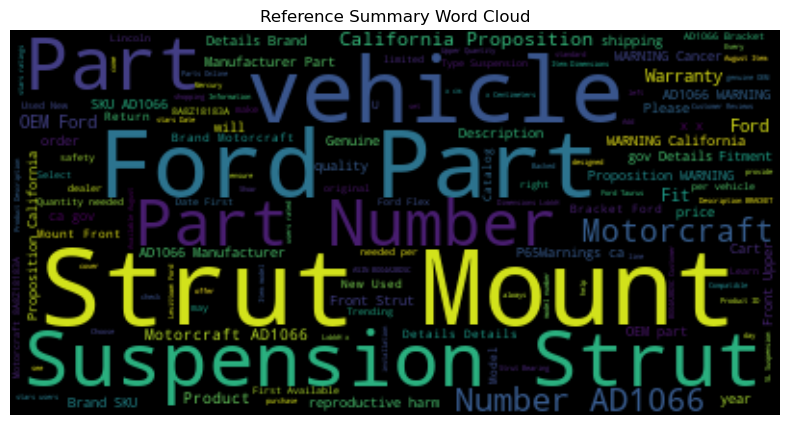

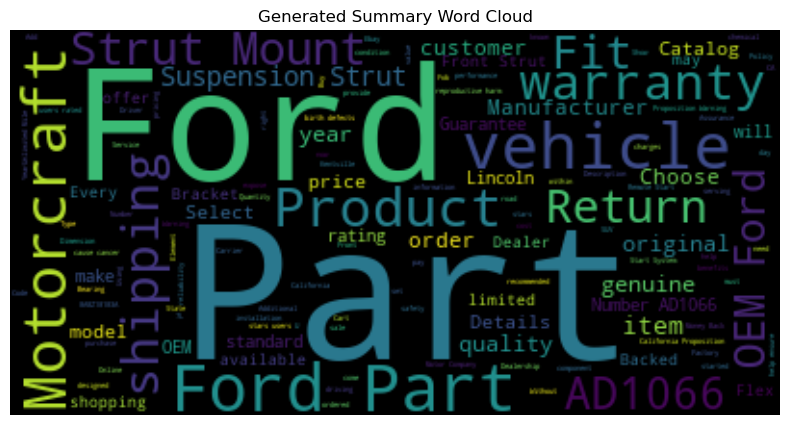

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Reference Summary Word Cloud
ref_wc = WordCloud().generate(reference_summary)
plt.figure(figsize=(10, 5))
plt.title("Reference Summary Word Cloud")
plt.imshow(ref_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generated Summary Word Cloud
gen_wc = WordCloud().generate(generated_summary)
plt.figure(figsize=(10, 5))
plt.title("Generated Summary Word Cloud")
plt.imshow(gen_wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [28]:
from nltk.tokenize import sent_tokenize
from transformers import pipeline, BartTokenizer
import re

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


def answer_question_over_chunks(question, text):
    qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")
    best_answer = {"answer": "", "score": 0}
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.2f})")

    return best_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")


question_answering_loop(summary)

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  what is the product



Possible Answers from Chunks:
- OEM parts (Score: 0.54)
- Flex (Score: 0.01)
- the VIN (Score: 0.38)
- select the make you are shopping for below (Score: 0.39)
- Ved Auto Impex Kundli (Score: 0.13)
- Valley Ford Kentville Technology (Score: 0.03)
- a geuine OEM part backed by a manufacturers warranty (Score: 0.50)
- Suspension Strut Mount Motorcraft (Score: 0.93)
- parts replacement with same or better quality (Score: 0.51)
- 11112010 (Score: 0.11)
- Submodel (Score: 0.14)
- Galleon (Score: 0.59)
- Ford Taurus (Score: 0.01)
- OEM Ford parts (Score: 0.51)
- Brand Motorcraft Manufacturer Part Number AD1066 eBay (Score: 0.04)
- MOTORCRAFT (Score: 0.36)
- Wheel Locks  ChromePlated (Score: 0.01)
- AD1066 (Score: 0.19)
- thisProduct (Score: 0.02)
- Ford parts that your Ford vehicle came with from the Factory (Score: 0.02)
- genuine Ford parts (Score: 0.02)
- 8A8Z18183A (Score: 0.06)
- Automatic Transmission Fluid ATF (Score: 0.35)
- Subcategory Shocks (Score: 0.07)
- it can often be replace


Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


In [30]:
def answer_question_over_chunks(question, text):
    qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
    best_answer = {"answer": "", "score": 0}
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.2f})")

    return best_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")

question_answering_loop(summary)


You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  what is the product


D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Possible Answers from Chunks:
- These parts are produced to the exact specifications and standards set by Ford (Score: 0.21)
- Genuine Factory OEM Ford Parts or Ford Motorcraft Parts (Score: 0.00)
- MOTORCRAFT Suspension Strut Mount contains no remanufactured components (Score: 0.01)
- The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles (Score: 0.03)
- Front Strut Bearing (Score: 0.27)
- Motorcraft struts (Score: 0.06)
- a geuine OEM part backed by a manufacturers warranty (Score: 0.19)
- This part may not fit your vehicle (Score: 0.00)
- parts replacement with same or better quality (Score: 0.07)
- 3-year-old model with a capacity of 2.7 liters (Score: 0.10)
- Return to Part listing (Score: 0.13)
- All products are genuine and original (Score: 0.20)
- In stock limited availability at this price! (Score: 0.10)
- unbeatable discount pricing along with the lowest shipping rates possible (Score: 0.01)
- Product Identifiers (Score: 0.01)
- Front Strut Bearing (S


Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


Google_Flan_T5

In [2]:
from nltk.tokenize import sent_tokenize
from transformers import pipeline, BartTokenizer
import re

# Load tokenizer and summarizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
summarizer = pipeline("summarization", model="google/flan-t5-large")

# Preprocess text
def preprocess_text(df, relevant_columns):
    text = " ".join(df[col].fillna("").astype(str).str.cat(sep=" ") for col in relevant_columns)
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    text = re.sub(r"[^\w\s.,!?]", "", text)  # Remove special characters
    sentences = sent_tokenize(text)  # Tokenize into sentences
    unique_sentences = list(set(sentences))  # Remove duplicate sentences
    text = " ".join(unique_sentences)
    return text

# Chunk text into smaller parts
def chunk_text_via_sentences(text, max_chunk_size):
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= max_chunk_size:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Merge small chunks
def merge_small_chunks(chunks, min_words_per_chunk=30):
    merged_chunks = []
    temp_chunk = ""

    for chunk in chunks:
        if len(chunk.split()) < min_words_per_chunk:
            temp_chunk += " " + chunk
        else:
            if temp_chunk.strip():
                merged_chunks.append(temp_chunk.strip())
                temp_chunk = ""
            merged_chunks.append(chunk)

    if temp_chunk.strip():
        merged_chunks.append(temp_chunk.strip())

    return merged_chunks

# Generate summaries for chunks
def generate_summary_parallel(text_chunks, max_length, min_length):
    summaries = []
    for chunk in text_chunks:
        print("______________________________________________________")
        print(chunk)
        try:
            summary = summarizer(chunk, max_length=max_length, min_length=min_length, truncation=True)[0]['summary_text']
            summaries.append(summary)
            print("-------------------------------------------------------")    
            print("Summaries:", summary)
        except Exception as e:
            print(f"Error processing chunk: {e}")
            summaries.append("")  # Append empty summary for error chunks
    return " ".join(summaries)

# Columns to summarize
columns_to_summarize = ['Product Name', 'Part_No from site', 'Cross Reference', 'Price', 'Specification', 'Details']

# Clean and summarize text
cleaned_text = preprocess_text(df, columns_to_summarize)
print("cleaned")
text_chunks = chunk_text_via_sentences(cleaned_text, max_chunk_size=200)  # Adjust chunk size as needed
print("chuked")
final_chunks = merge_small_chunks(text_chunks)
summary = generate_summary_parallel(final_chunks, max_length=200, min_length=10)

print("Generated Summary:\n", summary)

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


cleaned
chuked
______________________________________________________
For other parts, we provide a limited warranty of 90 days from the date received by the original purchaser or installer, unless otherwise specified, which covers the replacement of a defective parts. Item_Offered Quantity 1 Part_Number AD1066 Type Suspension Strut Mount Warranty 1 Year Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! To make sure this part fit your vehicle Check The Fit To make sure this part fit your vehicle Check The Fit Attention! Please click the Fitment tab below and confirm your engine, chassis and transmission. Policies Buy Ford Flex BRACKET. Every customer benefits from genuine OEM parts at the best possible pricing, 100 order accuracy, discounted shipping rates, and awardwinning customer service.
-------------------------------------------------------
Summaries: Ford Flex BRACKET Genuine OEM parts at the best po

Your max_length is set to 200, but your input_length is only 188. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


-------------------------------------------------------
Summaries: Full Diagram 18183 Required 2 Recommended Products Wheel Locks ChromePlated For Exposed Lugs E9TZ1A043A 84.00 Bumper Mounted Warning Sensors by Rosen Reverse VAS4Z15A866B 344.31 Racks and Carriers by THULE Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B 262.69 Remote Start System 2Button Fob with Confirmation JS7Z15K601B 150.00 Ash Cup Coin Holder Without Lighter Element 5L8Z7804810AAA 48.30 Sportz SUV Tents by Napier VAT4Z99000C38A 473.76 Dashcam VHL3Z19G490C 241.91 Remote Start System Key Fobs, BiDirectional, Programmable for VSS DL3Z15K601A 136
______________________________________________________
Accepted Payments Specifications Warranty Weight 3 Brand Motorcraft Part Number AD1066 Line Code MOP UPC 031508526778 Terminology Suspension Strut Mount Weight 3 For warranty information please contact AutoWares. Our simple onetime registration process will make ordering parts quick and easy. Available for Order Ha

Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


-------------------------------------------------------
Summaries: Motorcraft Brackets are designed and tested to Fords rigorous engineering standards.
______________________________________________________
Product information Technical Details Global Trade Identification Number 00031508526778 Product Dimensions 8.41 x 9.17 x 6.22 cm 1.36 kg Item model number AD1066 Manufacturer Part Number AD1066 OEM Part Number AD1066 Assembly Required No Item Weight 1 kg 360 g Additional Information ASIN B004A2BDSC Customer Reviews 4.1 4.1 out of 5 stars 6 ratings 4.1 out of 5 stars Date First Available 7 August 2012 Item Dimensions LxWxH 8.4 x 9.2 x 6.2 Centimeters Feedback Would you like to tell us about a lower price? When you use OEM parts, you can trust that they have undergone rigorous testing and quality control processes, providing you with peace of mind knowing your vehicle is equipped with components that meet Fords highquality standards.


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


-------------------------------------------------------
Summaries: The AD1066 is a replacement for the AD1066 OE part.
______________________________________________________
Using aftermarket parts may lead to compatibility issues, which can result in poor performance, decreased safety, and additional expenses down the road to fix problems that arise from using incompatible components.
-------------------------------------------------------
Summaries: Use aftermarket parts only when necessary. Do not use aftermarket parts on a vehicle that is not compatible with the original manufacturer's parts.
______________________________________________________
Read more MOTORCRAFT part description BRACKET MOTORCRAFT AD1066 Cross Reference We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A MOTORCRAFT XT1Q1F Automatic Transmission Fluid ATF  Type F  8.99 Automatic Transmission Fluid ATF  Type F MOTORCRAFT XT12QULV Automatic Transmission Oil  10.99 Automatic Transmission Oil MOTORCRAFT 

Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


-------------------------------------------------------
Summaries: MOTORCRAFT AD1066 Cross Reference
______________________________________________________
Please wait... Price and Stocks may change without prior notice Packaging of actual item may differ from photo shown Electrical items MAY be 110 volts. Therefore, the claim must be coordinated and processed through the shipping company by the customer. This covers all Ford Parts such as Air Filters, Belts, Brake Pads, Coils, Fuel Filters, Body Parts, Interior Parts, Ect. Interchange Description From 42308. This Fits Your Ford Flex Part Number  AD1066 Supersessions  8A8Z 18183A 8A8Z18183A   Spacer. Learn more Estimate shipping New! Description Specifications Warranty Information Related Parts Fits These Vehicles With Suspension A or Suspension B or Suspension C. Motorcraft struts help ensure a smooth ride under everchanging loads, road conditions and driving situations.
-------------------------------------------------------
Summarie

Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


-------------------------------------------------------
Summaries: Order your Bracket ad1066 for your vehicle today and have it delivered right to your home in a matter of days.
______________________________________________________
Every Genuine Original Factory Ford Part is sourced directly from our extensive inventory of Ford Parts Direct from Fords host of Warehouses. Restrictions May Apply. You can find out more about the exceptions and conditions here . We offer full catalogs for Ford, Lincoln, and Mercury vehicles. OEM Ford Parts Online OEM Ford Part Online Discount Catalog Ford Strut Mount 8A8Z18183A 20082011 OEM Ford Part is an Authorized Ford Wholesale Distributor of OEM Ford Parts  OEM Genuine Ford Accessories . We understand the importance of saving time and money when shopping for genuine Ford parts which is why we offer upfront discounted pricing and fast order processing. The warranty does not cover airfreight charges, labor expenses, towing expenses, or rental car expen

Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


-------------------------------------------------------
Summaries: Ford Flex AD1066 Get complimentary shipping on purchases of 75 or more before tax. Our goal is to provide every Ford customer with excellent service, unbeatable discount pricing along with the lowest shipping rates possible! From 42308. Every order is manually reviewed by our trained automotive parts professionals to guarantee VINtopart accuracy.
______________________________________________________
Ved Auto Impex Kundli, Sonipat, Haryana 5 5    2  GST  06ANHPA6948F1Z2 Verified Supplier Select the department you want to search in Product description Front Strut Bearing Product description Front Strut Bearing Front Strut Bearing Product information Technical Details Global Trade Identification Number 00031508526778 Product Dimensions 8.41 x 9.17 x 6.22 cm 1.36 kg Item model number AD1066 Manufacturer Part Number AD1066 OEM Part Number AD1066 Assembly Required No Item Weight 1 kg 360 g Additional Information ASIN B004A2B

Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


-------------------------------------------------------
Summaries: By Vehicle By Category By Part Type By Manufacturer By KeywordPart Number Import contacts Google Yahoo!
______________________________________________________
Additionally, having a wellmaintained vehicle with OEM parts can make it more appealing to potential buyers. In stock orders submitted before 3pm EST daily will be shipped the same day. Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Levittown Ford Parts LevittownFordParts.com operates as a division of Levittown Ford located in NY. Learn more Estimate shipping Quantity Minus Plus QUICK CHECKOUT Pay with Apple Pay Add to Cart Motorcraft AD1066  BRACKET Part Number AD1066 Manufacturer MOTORCRAFT Descripti

Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


-------------------------------------------------------
Summaries: Motorcraft AD1066 BRACKET Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details 109 .
______________________________________________________
Continue to Cart Cancel Dealer Rating 4.5 5 2 Reviews See Reviews Your Price  172.51 CAD   Add to Cart Select product options Valley Ford Kentville 898 Park Street, Kentville , NS, B4N 3V7 902 6781330 Email Us Policies  Information Return Policy We will accept authorised returns 15 calendar days after the date of the shipments delivery. Not only that, the Ford Parts you purchase are an identical standard of quality as the Ford parts that your Ford vehicle came with from the Factory . As A genuine Ford parts dealership we have access to Fords entire parts inventory. Specifications Warranty Weight 3 Brand Motorcraft Part Number AD1066 Line Code MOP UPC 031508526778 Terminology Suspension Strut Mount Weight 3 For warranty information please contact AutoWares. FordPart

Your max_length is set to 200, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


-------------------------------------------------------
Summaries: Valley Ford Kentville 898 Park Street, Kentville , NS, B4N 3V7 902 6781330
______________________________________________________
7 Day Return Policy All products are genuine and original Pay with About Motorcraft AD1066 Strut Mount Front Strut Bearing View Reviews Motorcraft AD1066 Strut Mount Product ID  22029700 Share Tweet share more ShareThis Google  LinkedIn Tumblr Email Galleon Product ID 22029700 Model Manufacturer Shipping Dimension Unknown Dimensions I think this is wrong? The warranty applies only to parts replacement with same or better quality. For such cases, a full refund will be issued to the original purchaser.


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


-------------------------------------------------------
Summaries: No, the warranty applies only to parts replacement with same or better quality. For such cases, a full refund will be issued to the original purchaser.
______________________________________________________
Accepted Payments Close VIN entry layer Enter VIN Enter 17 digit VIN here Go About About Ford Ford.ca Explore Ford Parts Warranty Legal Policies Links Dealer Home My Information Testimonials Valley Ford Kentville 902 6781330 898 Park Street, Kentville , NS, B4N 3V7 tabitha.littlevalleyford.ns.ca While every reasonable effort is made to ensure the accuracy of this data, we are not responsible for any errors or omissions contained on these pages.


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


-------------------------------------------------------
Summaries: Valley Ford Kentville 902 6781330 898 Park Street, Kentville , NS, B4N 3V7
______________________________________________________
Learn More About this item Item description from the seller Front Strut Mount by MOTORCRAFT  AD1066 Select Vehicle year To Guarantee Fit Grade Economy Driver Profile Budget Driver Incentive BudgetSaver Conforms To Safety Standards Addresses the issue without breaking the wallet Precision Original Fit Fitment on par with OEM OE Quality Assurance Exact Size  Dimensions Finishing NonCoated MOTORCRAFT SKU 63x66ol2x3 Motorcraft AD1066  BRACKET Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details  109 . Aftermarket parts may not offer the same level of warranty coverage, leaving you financially vulnerable if issues arise. Because the customer is the shipper, heshe is the only one who can file any lost claim with the shipping company. This part may not fit your vehicle!


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


-------------------------------------------------------
Summaries: This item may not fit your vehicle! .
______________________________________________________
Read more MOTORCRAFT part description BRACKET MOTORCRAFT AD1066 Cross Reference We have 1 alternatives for the AD1066 by MOTORCRAFT 8A8Z18183A 8A8Z18183A Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! When it comes to your Ford, always opt for the quality and reliability that OEM parts provide. All returned items must have the RA Return Authorization number written outside the shipping box prior to return. Buyers often prefer vehicles with genuine OEM parts, as they are seen as more reliable and trustworthy.
-------------------------------------------------------
Summaries: MOTORCRAFT AD1066 Cross Reference
______________________________________________________
49  8.99  10.99  9.49  38.49  254.49  76.99 MSRP 136.91 Discount 48

Your max_length is set to 200, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


-------------------------------------------------------
Summaries: No, we are not currently accepting comments on this product
______________________________________________________
Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details OEM Ford Parts Direct We are here to help you with any project you undergo. Quality Assurance One of the primary reasons to choose OEM Ford parts is the assurance of quality.
-------------------------------------------------------
Summaries: Details Details Brand SKU AD1066 WARNING California Proposition 65 California Proposition 65 WARNING Cancer and reproductive harm www.P65Warnings.ca.gov Details Brand SKU AD1066 WARNING California Proposition 65 California Proposition 65 WARNING Cancer and repro

Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


-------------------------------------------------------
Summaries: Get a 20 OFF 100 Coupon Code for your next purchase.
______________________________________________________
SHOW MORE  CONFIRM THIS FITS YOUR Ford Flex Ford Flex  Suspension and Steering Products Select a Year 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 BRACKET. Because you are our 1 priority. This compatibility ensures that the parts will fit seamlessly and work harmoniously with the rest of your vehicles components. Select a Vehicle Ford Taurus X 2008  2009 Mercury Sable 2008  2009 Ford Taurus 2008  2011 Ford Flex 2009 Lincoln MKS 2009  2011 Package Quantity 1 Weight 4.23 lbs Dimensions 6.25 L x 6.25 W x 5.1 H in Apply eBay Money Back Guarantee Get the item you ordered or your money back.


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


-------------------------------------------------------
Summaries: This item is in sale since Monday, December 10, 2018. This item is in the category "eBay MotorsParts & AccessoriesCar & Truck PartsSuspension & SteeringOther Auto & Truck PartsSuspension & Steering Kits". The seller is "eBay MotorsParts & AccessoriesCar & Truck PartsOther Auto & Truck PartsSuspension & Steering Kits" and is located in United States.
______________________________________________________
Other than applicable manufacturer warranties, or as otherwise provided in these Terms  Conditions, there are no warranties, express or implied for any of our products, and we specifically disclaim any warranty of merchantability or fitness for a particular purpose for tires, aftermarket wheels, and tire  aftermarket wheel packages. Motorcraft parts fit right the first time for quicker, easier installation. Ask us anything about the parts or accessories youre shopping for, were more than happy to help! Try searching by o

Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


-------------------------------------------------------
Summaries: Search for: Tires, aftermarket wheels, and tire aftermarket wheel packages
______________________________________________________
Manufacturer Ford Part Number ad1066 Manufacturer Ford Part Number ad1066 Details Brand SKU ad1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Brand SKU ad1066 WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Details Details Brand SKU 8A8Z18183A Positions Left Upper, Right Upper Other Names Upper Mount, Bracket, ad1066 Description From 42308. Learn more eBay Money Back Guarantee  opens new window or tab Seller assumes all responsibility for this listing.
-------------------------------------------------------
Summaries: The item "Ford Part Number ad1066" is in sale since Monday, December 10, 2018. This item is in the categor

Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


-------------------------------------------------------
Summaries: Part Number AD1066 Manufacturer MOTORCRAFT Description BRACKET details 109 . This Fits Your Ford Flex Part Number AD1066 Supersessions 8A8Z 18183A 8A8Z18183A Spacer. Select a Vehicle Ford Taurus X 2008 2009 Mercury Sable 2008 2009 Ford Taurus 2008 2011 Ford Flex 2009 Lincoln MKS 2009 2011 With Suspension A or Suspension B or Suspension C. Motorcraft struts help ensure a smooth ride under everchanging loads, road conditions and driving situations. Condition 100 New in factory packaging, never used or installed.
______________________________________________________
Check The Fit Short Product Description Suspension Strut Mount CTO US Harmonized Tariff Code HTS 8302303060 Maximum Cases per Pallet Layer 42 Pallet Layer Maximum 6.0000 Description Fitments Warranty Product Details Manufacturer Motorcraft Part Number AD1066 Manufacturer Part Number AD1066 Description Suspension Strut Mount Long Description Part Type Suspensio

Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


-------------------------------------------------------
Summaries: This part fits at least 13 vehicles. Year Make Model Engine Notes 2011 Ford Taurus 3.5L Suspension Strut Mount Front Upper Natural Quantity needed per vehicle 2 2011 Lincoln MKS 3.7L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2010 Lincoln MKS 3.7L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2010 Lincoln MKS 3.7L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2009 Ford Flex 3.5L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2009 Ford Taurus 3.5L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2009 Lincoln MKS 3.7L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2009 Mercury Sable 3.5L Suspension Strut Mount Front Upper Quantity needed per vehicle 2 2008 Ford Taurus 3.5L Sus
______________________________________________________
Compatibility OEM Ford parts are designed to be compatible with your specific Ford

Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


-------------------------------------------------------
Summaries: California Proposition 65 Warning WARNING This product can expose you to chemical which is known to the State of California to cause cancer and birth defects or other reproductive harm.
______________________________________________________
WARNING  California Proposition 65  California Proposition 65 WARNING  Cancer and reproductive harm  www.P65Warnings.ca.gov Details Description From 42308. Warranty is supported nationwide by FordLincoln dealers and Ford Authorized Distributors. Garage You have no vehicles in your online garage. As with all Motorcraft and Ford Parts, any innovations or improvements developed since the vehicles manufacture are included in these after market replacement parts, ensuring the most current technology and performance. Use coupon code FORDPROMO at checkout up to 100 value Only at Participating Retailers. Backed by the Motorcraft Service Parts Warranty which offers 2 years, unlimited mileage,

Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


-------------------------------------------------------
Summaries: 2025 Valley Ford Kentville Technology powered by SimplePart CONFIRM THIS FITS YOUR FORD Flex Ford Flex Suspension and Steering Products Select a Year 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 BRACKET. Checking Price and Availability ... Learn more eBay Money Back Guarantee Get the item you ordered or your money back. Accepted Payments BRACKET. Reliability is crucial when it comes to vehicle maintenance, as it helps you avoid costly repairs and ensures your Ford continues to perform at its best. Ford Shop Genuine OEM Ford Parts Online 8A8Z18183A Ford Part Number, this part number refers to the Strut Mount and is used in the following Ford Fitment Applications 20082011 All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile Warranty that is valid at any Ford Dealership Worldwide.
______________________________________________________
Interchange OEM Ford Parts Dir

Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


-------------------------------------------------------
Summaries: OEM Ford Parts Direct We are here to help you with any project you undergo. All items must be in their original condition and must not be damaged due to incorrect installation upon return. A refund or an exchange of a defective part will be processed only if it is accompanied by the original sales invoice. Last Used To Write your comment here...
______________________________________________________
VAT    Shipping cost  Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 12  01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  Store Offline Store name   Enter the store name where you found this product Enter the store name where you found this product TownCity   State Please select province Please select province Price incl. 49 In stock limited availability at this price! All items are given a limited 90days warranty period by the manufacturer. The only parts recommended

Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


-------------------------------------------------------
Summaries: Welcome to FordParts.com. We carry a wide selection of suspension parts for your Ford vehicle.
______________________________________________________
Additional benefits include Save vehicles by VIN for easier and more accurate searching Receive special offers and promotions via email Express checkout with stored shipping and billing details _FreeShippingReLogonFormESpot_ null Offer valid through 13125 on qualifying purchases made before tax. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below  Ford Models  Lincoln Models  Mercury Models  Suspension Strut Mount The only parts recommended by Ford Motor Company for Ford and Lincoln vehicles. The manufacturer will allow the parts to be covered by their warranty provided that the part was not modified by the buyer. Shop more Ford Parts here! Conclusion In conclusion, choosing OEM Ford parts

Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


-------------------------------------------------------
Summaries: Motorcraft AD1066 Suspension Strut Mount Bracket left, right, front 3.7l Suspension Strut Mount Motorcraft AD1066 Suspension Strut Mount Motorcraft AD1066 Home Replacement Suspension Strut Mounts Front Strut Mounts Front Strut Mounts Part AD1066 Front Strut Mount by MOTORCRAFT
______________________________________________________
To avoid this, cancel and sign in to YouTube on your computer. This genuine OEM Ford part, when sold  used within the U.S., is guaranteed by Ford  Motorcraft Parts Limited Warranty. Whether you are an Auto Repair Professional or a Do It Yourself Consumer you always have the option to speak with a Genuine Ford Parts Specialist MondayFriday 8am5pm to ask questions and ensure you feel confident about your OEM Ford Parts Online order. We provide Ford, Lincoln, Mercury, as well as Factory Ford Motorcraft Parts Online. If your Ford is noisier than usual on bumpy roads or under braking, you may need 

Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


-------------------------------------------------------
Summaries: Your Price 172.51 CAD Dealer price excludes taxes, installation, shipping, and dealer charges.
______________________________________________________
VAT    Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 12  01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  Submit Feedback Please sign in to provide feedback. Notes Order by application and code. 200912, from 11112010, with 3.7L.
-------------------------------------------------------
Summaries: VAT Date of the price MMDDYYYY 01 02 03 04 05 06 07 08 09 10 11 12 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
______________________________________________________
Learn more Estimate shipping Quantity Minus Plus QUICK CHECKOUT Pay with Apple Pay Add to Cart details details Details Details Brand SKU AD1066 WARNING  California Proposition 65  California Proposition 65 WARNING

Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


-------------------------------------------------------
Summaries: TascaParts is a family owned business that has been in business for over 50 years.
______________________________________________________
Flex. Interchange Ford Parts Catalog Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers across the country for over 30 years. Suspension  OEM Ford Part  AD1066 8A8Z 18183A, 8A8Z18183A Accessories Parts EN Go Search by Keywords, Part Numbers or Full VIN Go X Ford Flex My Garage  You can edit the name of your vehicle by clicking the pencil icon on the right. for destinations within the 50 states. OEM Ford parts are designed with safety in mind. Under NO circumstances will our liability exceed the amount of the original sale. For over 60 years, Tasca Automotive has put customer satisfaction above all else.


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


-------------------------------------------------------
Summaries: Flex. Interchange Ford Parts Catalog Backed by the experienced and capable staff serving a highvolume Ford dealership in Connecticut, we at the Ford Parts Catalog have been serving Ford drivers across the country for over 30 years.
______________________________________________________
5 off for eligible customers For your prices and availability select a dealer Select attributes to see availability Qty Add To Cart For your prices and availability select a dealer Select attributes to see availability suspension strut mount bracket  left, right, front 3.7l Part  AD1066 8A8Z18183A Usages Part  For your prices and availability select a dealer Select attributes to see availability Mobile Service installation available MSRP 136.91 Save with FordPass  Rewards You can now redeem Points for discounts on Ford Parts. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you 

Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


-------------------------------------------------------
Summaries: Fits Flex 2009 2010 Diagrams and Kits What This Fits Attachments Product Types Front Suspension Struts and Springs.
______________________________________________________
Videos you watch may be added to the TVs watch history and influence TV recommendations. Shop Genuine OEM Ford Parts Online  8A8Z18183A Ford Part Number, this part number refers to the Strut Mount and is used in the following Ford Fitment Applications 20082011 All OEM Ford Parts on our Genuine Original Ford Parts Online Catalog come with a 2 YearUnlimited Mile Warranty that is valid at any Ford Dealership Worldwide. These parts are produced to the exact specifications and standards set by Ford, which means they are designed to fit perfectly and perform flawlessly in your vehicle.
-------------------------------------------------------
Summaries: 8A8Z18183A Ford Part Number, this part number refers to the Strut Mount and is used in the Ford Fitment Appl

Your max_length is set to 200, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


-------------------------------------------------------
Summaries: The MOTORCRAFT Suspension Strut Mount contains no remanufactured components, and is designed to operate in either city or highway driving.
______________________________________________________
If a genuine OEM part fails within the warranty period, it can often be replaced at no additional cost to you, saving you money in the long run.
-------------------------------------------------------
Summaries: If you are not satisfied with the quality of the part, you can return it for a refund.
______________________________________________________
Motorcraft AD1066 Strut Mount Bracket  Ford ad1066 Bracket  Ford ad1066 Antenna Mast Antenna Mast Trim Panel Trim Panel Mirror Glass  Passenger Side RH Mirror Glass  Passenger Side RH Wheel Cover Wheel Cover SunVisor  Drivers Side LH SunVisor  Drivers Side LH Antenna Mast Antenna Mast Trim Panel Trim Panel Mirror Glass  Passenger Side RH Mirror Glass  Passenger Side RH Strut Mount  

Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


-------------------------------------------------------
Summaries: false KeywordPart Part Part Part SKU MIAD1066 Manufacturer Part Number AD1066 AD1066 SKU AD1066 AD1066 Part Number AD1066 Part Number Supersessions Part AD1066 Part AD1066 This part fits vehicles with your year, make and model.
______________________________________________________
Therefore, its valid at any Authorized Ford Dealer in the world. As you search, vehicles will automatically be added to your garage. The RA Numbers can be obtained by creating a return from within your account. To get started shopping for parts that fit your specific vehicle, all you need to do first is select the make you are shopping for below  Ford Models  Lincoln Models  Mercury Models  We are here to help you with any project you undergo. Updating Price ... Price Tracker via AIR via SEA Get quote for sea shipping This item ships longer than average delivery time. Condition New Product Fit Direct Fit Weight 4.23 lbs.
---------------------

Your max_length is set to 200, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


-------------------------------------------------------
Summaries: a, b, c. 201012, with susp.
______________________________________________________
For more information, go to www.P65Warnings.ca.gov. If you have any questions or need any assistance finding the right Ford part for your car or truck please drop us a line or chat directly with one of our agents. When you choose OEM Ford parts, you are investing in the longevity of your vehicle. Offer applies to FedEx standard shipping only, up to 40 lbs.
-------------------------------------------------------
Summaries: Offer applies to FedEx standard shipping only, up to 40 lbs.
______________________________________________________
Fits Flex 2009  2010 Wheel Locks  ChromePlated For Exposed Lugs E9TZ1A043A  84.00 Bumper Mounted Warning Sensors by Rosen  Reverse VAS4Z15A866B  344.31 Racks and Carriers by THULE  Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B  262.69 Remote Start System  2Button Fob with Confirmation JS7Z15K601B 

Your max_length is set to 200, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


-------------------------------------------------------
Summaries: Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Please check top Automotive Fitment Filter and Description to see if this item will work on your vehicle before purchase! Product Description Fitment Pleas

Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


-------------------------------------------------------
Summaries: GENUINE NISSAN 0010 FRON
______________________________________________________
From the pioneering days of Henry Fords assembly line, quality has always been an integral component of Ford. Shopping for a different vehicle? Contact Us Here.
-------------------------------------------------------
Summaries: The Ford Motor Company is a publicly traded company headquartered in Dearborn, Michigan.
Generated Summary:
 Ford Flex BRACKET Genuine OEM parts at the best possible pricing, 100 order accuracy, discounted shipping rates, and awardwinning customer service. Full Diagram 18183 Required 2 Recommended Products Wheel Locks ChromePlated For Exposed Lugs E9TZ1A043A 84.00 Bumper Mounted Warning Sensors by Rosen Reverse VAS4Z15A866B 344.31 Racks and Carriers by THULE Paddleboard Carrier, RackMounted, Standup VFT4Z7855100B 262.69 Remote Start System 2Button Fob with Confirmation JS7Z15K601B 150.00 Ash Cup Coin Holder Without Li

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Reference summary (gold standard) and generated summary
reference_summary = " ".join(final_chunks) 
generated_summary = summary

# Step 1: Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer()

# Fit the vectorizer on both summaries and transform into vectors
tfidf_matrix = vectorizer.fit_transform([reference_summary, generated_summary])

# Step 2: Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# Print cosine similarity score
print("TF-IDF Cosine Similarity Score:", cosine_sim[0][0])


TF-IDF Cosine Similarity Score: 0.8589348479481116


In [6]:
from rouge import Rouge

# Reference and generated summaries
reference_summary = " ".join(final_chunks)
generated_summary = summary

# Initialize ROUGE
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(generated_summary, reference_summary)
print("ROUGE-1:", scores[0]['rouge-1'])
print("ROUGE-2:", scores[0]['rouge-2'])
print("ROUGE-L:", scores[0]['rouge-l'])

ROUGE-1: {'r': 0.36150770988006853, 'p': 0.922740524781341, 'f': 0.5194911736323728}
ROUGE-2: {'r': 0.24305216967333007, 'p': 0.8308333333333333, 'f': 0.3760844929143555}
ROUGE-L: {'r': 0.3592233009708738, 'p': 0.9169096209912536, 'f': 0.516208448970904}


In [7]:
from bert_score import score

# Compare generated and reference summaries
P, R, F1 = score([generated_summary], [reference_summary], lang="en", verbose=True)
print(f"BERTScore - Precision: {P.item()}, Recall: {R.item()}, F1: {F1.item()}")

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.59 seconds, 0.39 sentences/sec
BERTScore - Precision: 0.8800830245018005, Recall: 0.8719772100448608, F1: 0.8760114312171936


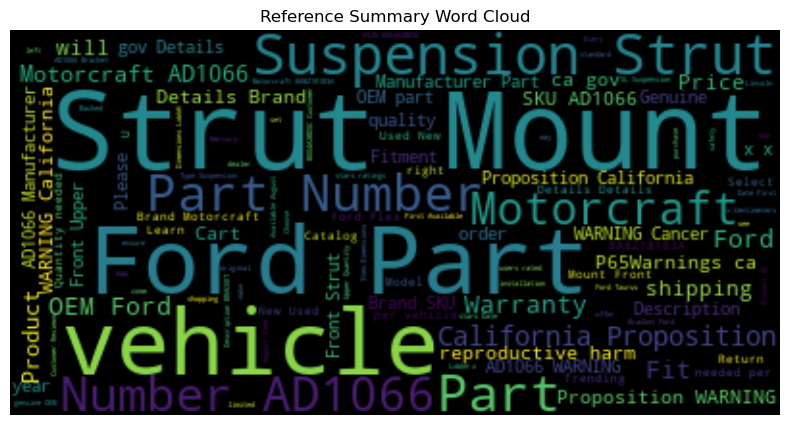

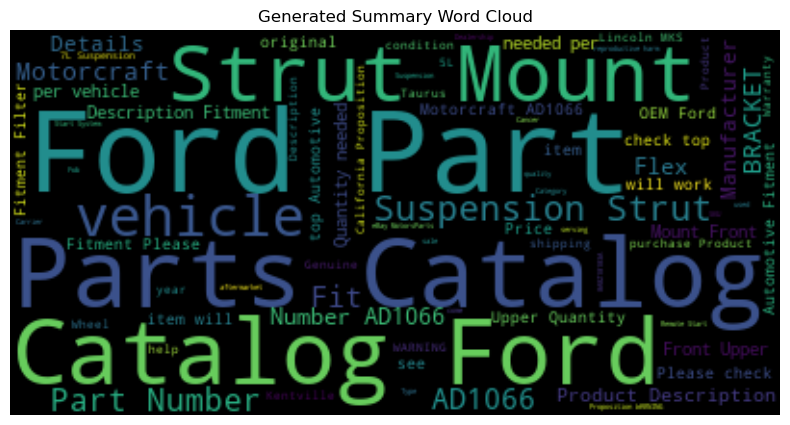

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Reference Summary Word Cloud
ref_wc = WordCloud().generate(reference_summary)
plt.figure(figsize=(10, 5))
plt.title("Reference Summary Word Cloud")
plt.imshow(ref_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generated Summary Word Cloud
gen_wc = WordCloud().generate(generated_summary)
plt.figure(figsize=(10, 5))
plt.title("Generated Summary Word Cloud")
plt.imshow(gen_wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [37]:
from nltk.tokenize import sent_tokenize
from transformers import pipeline, BartTokenizer
import re

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


def answer_question_over_chunks(question, text):
    qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")
    best_answer = {"answer": "", "score": 0}
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.2f})")

    return best_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")


question_answering_loop(summary)


You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  what is the product



Possible Answers from Chunks:
- OEM Ford Parts and accessories (Score: 0.58)
- Flex (Score: 0.00)
- Ford Fitment Applications 20082011 (Score: 0.21)
- Ved Auto Impex Kundli (Score: 0.24)
- Tasca Automotive is an authorized dealer of OEM Ford parts (Score: 0.27)
- Home Replacement (Score: 0.07)
- 11112010, with 3.7L (Score: 0.23)
- 2011 (Score: 0.40)
- QUICK CHECKOUT Pay (Score: 0.03)
- Amazon.com (Score: 0.86)
- 2 Your Price (Score: 0.62)
- Choose OEM Ford parts for your vehicle (Score: 0.44)
- P65Warnings.ca.gov (Score: 0.73)
- 0 Your Cart Close Cart (Score: 0.03)
- Budget Driver Incentive BudgetSaver (Score: 0.03)
- MSRP 136 (Score: 0.06)
- Ford parts (Score: 0.28)
- Ford Flex Suspension and Steering Products Check the Fit Short Product Description (Score: 0.14)
- Warranty (Score: 0.61)
- TascaParts New (Score: 0.02)

Best Answer: Amazon.com



Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


In [3]:
def answer_question_over_chunks(question, text):
    qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
    best_answer = {"answer": "", "score": 0}
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    for sentence in sentences:
        new_chunk = " ".join(current_chunk + [sentence])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(sentence)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.2f})")

    return best_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")

question_answering_loop(summary)


You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  what is the product


D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Possible Answers from Chunks:
- awardwinning customer service (Score: 0.06)
- Wheel Locks (Score: 0.00)
- The AD1066 is a replacement for the AD1066 OE part (Score: 0.03)
- Ford Strut Mount (Score: 0.02)
- This item may not fit your vehicle (Score: 0.17)
- we are not currently accepting comments (Score: 0.00)
- Ford Part Number ad1066 (Score: 0.01)
- vehicle service, accessories, parts, vehicle purchases and more (Score: 0.01)
- Condition 100 New in factory packaging (Score: 0.24)
- This part fits at least 13 vehicles (Score: 0.08)
- can expose you to chemical (Score: 0.02)
- AD1066 (Score: 0.20)
- ensures your Ford continues to perform at its best (Score: 0.02)
- California Proposition 65 Warning WARNING (Score: 0.01)
- Dealer price excludes taxes, installation, shipping, and dealer charges (Score: 0.14)
- Front Suspension Struts and Springs (Score: 0.19)
- they are designed to fit perfectly and perform flawlessly in your vehicle (Score: 0.05)
- MOTORCRAFT Suspension Strut Mount cont


Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


In [47]:
from transformers import pipeline, AutoTokenizer
from nltk.tokenize import word_tokenize

# Initialize tokenizer and model pipeline
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

def answer_question_over_chunks(question, text):
    best_answer = {"answer": "", "score": 0}
    words = word_tokenize(text)  # Tokenize text into words
    chunks, current_chunk = [], []

    # Form chunks based on word tokenization
    for word in words:
        new_chunk = " ".join(current_chunk + [word])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(word)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    # Process each chunk with the QA pipeline
    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            # Expand answer to include surrounding words (context) for sentences
            expanded_answer = expand_to_sentence(result['answer'], chunk)
            result['answer'] = expanded_answer
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.2f})")

    return best_answer

def expand_to_sentence(answer, context):
    """Expand the answer to the nearest sentence in the context."""
    start_idx = context.find(answer)
    if start_idx == -1:  # If the answer is not found in the context
        return answer

    # Find the boundaries of the sentence
    before = context[:start_idx].rsplit('.', 1)[-1].strip()
    after = context[start_idx + len(answer):].split('.', 1)[0].strip()
    expanded_answer = f"{before} {answer} {after}".strip()
    return expanded_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")

question_answering_loop(summary)

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  What is the part number here?



Possible Answers from Chunks:
- 4 Centimeters Item details Global Trade Identification Number 00033342495036 (Score: 0.00)
- Stant engine coolant Reservoir Cap is part of the 10249 product line (Score: 0.01)
- for the STANT 10249 (Score: 0.00)
- STANT 10249 Part 10249 Brand STANT SOLD OUT Dont worry , available soon 4 (Score: 0.01)
- Where did you see a lower price ? Goodyear GATORBACK 4050435 296438546255 bb 300 (Score: 0.00)
- Ebay item number 185982149274 Last updated on Aug 22 , 2024 063758 PDT (Score: 0.00)
- V10 DIESEL SOHC Turbocharged ,5 (Score: 0.01)
- G79310593 296664713642 r9 12 Feedback left by buyer (Score: 0.00)
- New Safety Release Radiator Cap 18psi STANT LevRVent 10334 296771244078 8b 465 Feedback left by buyer (Score: 0.00)
- 51janej Keyed Alike Locking Fuel Caps with 4 Keys STANT 21591 Made in USA 296671099738 ae 2709 (Score: 0.01)
- AAAAA Locking Fuel Tank Cap Gas Cap with Keys Vintage Chrome STANT 10571 296308628964 ld 2363 Feedback left by buyer (Score: 0.00)
- V


Your Question (type 'exit' to quit):  what are the available part numbers?



Possible Answers from Chunks:
- 4 Centimeters Item details Global Trade Identification Number 00033342495036 (Score: 0.00)
- 90 days of warranty on other products SKU 3jvlxqzjw3 KWD 21 L4 FULL HYBRID EVGAS FHEV DOHC Turbocharged, 2.0L 198 4CC 121Cu (Score: 0.00)
- We have 16 alternatives for the 10249 by STANT (Score: 0.03)
- STANT 10249 Part 10249 Brand STANT SOLD OUT Dont worry , available soon 4.6 5 5 reviews CA 11 .23 Notify Me Super fast shipping (Score: 0.01)
- DOHC Naturally Aspirated ,5 (Score: 0.00)
- Ebay item number 185982149274 Last updated on Aug 22 , 2024 063758 PDT (Score: 0.00)
- The engine types may include 1.4L 1395CC 85Cu (Score: 0.11)
- 3.2L 3123CC V6 GAS DOHC Naturally Aspirated , 3 (Score: 0.00)
- New Safety Release Radiator Cap 18psi STANT LevRVent 10334 296771244078 8b 465 Feedback left by buyer (Score: 0.00)
- 51janej Keyed Alike Locking Fuel Caps with 4 Keys STANT 21591 Made in USA 296671099738 ae 2709 (Score: 0.01)
- 0L 1967CC 120Cu (Score: 0.00)
- To confir


Your Question (type 'exit' to quit):  what is the dimension of the product



Possible Answers from Chunks:
- Measurements Item Weight 63 g Item Dimensions 8.6 x 8.1 x 6.4 Centimeters Item details Global Trade Identification Number 00033342495036 (Score: 0.89)
- 0L 198 4CC 121Cu (Score: 0.00)
- 3.0L 2997CC 183Cu (Score: 0.00)
- Engine Coolant Thermostat Housing BEHR Thermostats TM 13 97 Made in Germany 296784892901 mm 70 (Score: 0.05)
- DOHC Naturally Aspirated ,5 (Score: 0.00)
- AAAAA Locking Fuel Tank Cap Gas Cap with Keys Vintage Chrome STANT 10571 296308628964 2.0 1 product (Score: 0.00)
- Would recommend Good value Good quality Would recommend (Score: 0.00)
- Measurements Item Weight 63 g Item Dimensions 8.6 x 8.1 x 6.4 Centimeters (Score: 0.76)
- It was well packaged and arrived in good shape (Score: 0.00)
- V6 GAS DOHC Naturally Aspirated, 3.6L 3597CC 219Cu (Score: 0.01)
- Past 6 months Verified purchase Item came just as described and was delivered right on time (Score: 0.00)
- Locking Gas Cap Locking Fuel Tank Cap with Keys Vintage Chrome STANT G793105


Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


In [55]:
from transformers import pipeline, AutoTokenizer
from nltk.tokenize import word_tokenize

# Initialize tokenizer and model pipeline
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

def answer_question_over_chunks(question, text):
    best_answer = {"answer": "", "score": 0}
    words = word_tokenize(text)  # Tokenize text into words
    chunks, current_chunk = [], []

    # Form chunks based on word tokenization
    for word in words:
        new_chunk = " ".join(current_chunk + [word])
        if len(tokenizer.encode(new_chunk, truncation=False)) <= 150:
            current_chunk.append(word)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    # Process each chunk with the QA pipeline
    answers = []
    for chunk in chunks:
        try:
            result = qa_pipeline(question=question, context=chunk)
            # Expand answer to include surrounding words (context) for sentences
            expanded_answer = expand_to_sentence(result['answer'], chunk)
            result['answer'] = expanded_answer
            answers.append(result)
            if result['score'] > best_answer['score']:
                best_answer = result
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Aggregate and display multiple answers
    print("\nPossible Answers from Chunks:")
    for ans in answers:
        print(f"- {ans['answer']} (Score: {ans['score']:.8f})")

    return best_answer

def expand_to_sentence(answer, context):
    """Expand the answer to the nearest sentence in the context."""
    start_idx = context.find(answer)
    if start_idx == -1:  # If the answer is not found in the context
        return answer

    # Find the boundaries of the sentence
    before = context[:start_idx].rsplit('.', 1)[-1].strip()
    after = context[start_idx + len(answer):].split('.', 1)[0].strip()
    expanded_answer = f"{before} {answer} {after}".strip()
    return expanded_answer

def question_answering_loop(text):
    print("\nYou can now ask questions about the summary.")
    print("Type 'exit' to quit the Q&A session.")
    
    while True:
        user_question = input("\nYour Question (type 'exit' to quit): ").strip()
        
        if user_question.lower() == "exit":
            print("Thank you for using the Q&A session. Goodbye!")
            break
        
        if not user_question:
            print("Please enter a valid question.")
            continue

        best_answer = answer_question_over_chunks(user_question, text)
        
        if best_answer['answer']:
            print("\nBest Answer:", best_answer['answer'])
        else:
            print("Sorry, no suitable answer found.")

question_answering_loop(summary)

D:\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



You can now ask questions about the summary.
Type 'exit' to quit the Q&A session.



Your Question (type 'exit' to quit):  part name



Possible Answers from Chunks:
- Stant 21591 made in USA 296671099738 ic 1296 Feedback left by buyer (Score: 0.00000033)
- Stant engine coolant Reservoir Cap is part of the 10249 product line (Score: 0.00000191)
- Stant engine coolant Reservoir Cap is part of the STANT part description (Score: 0.00358841)
- STANT 10249 Part 10249 Brand STANT SOLD OUT Dont worry , available soon 4 (Score: 0.13511719)
- DOHC Naturally Aspirated ,5 (Score: 0.00001786)
- Stant Stant is a brand of Stant (Score: 0.00000145)
- V10 DIESEL SOHC Turbocharged ,5 (Score: 0.00061236)
- G79310593 296664713642 r9 12 Feedback left by buyer (Score: 0.00000054)
- New Safety Release Radiator Cap 18psi STANT LevRVent 10334 296771244078 8b 465 Feedback left by buyer (Score: 0.00001396)
- 51janej Keyed Alike Locking Fuel Caps with 4 Keys STANT 21591 Made in USA 296671099738 ae 2709 (Score: 0.00000030)
- coolant cap for threaded filler neck (Score: 0.00000053)
- Verified purchase Yes Condition New Sold by partsmarvel Most re


Your Question (type 'exit' to quit):  exit


Thank you for using the Q&A session. Goodbye!


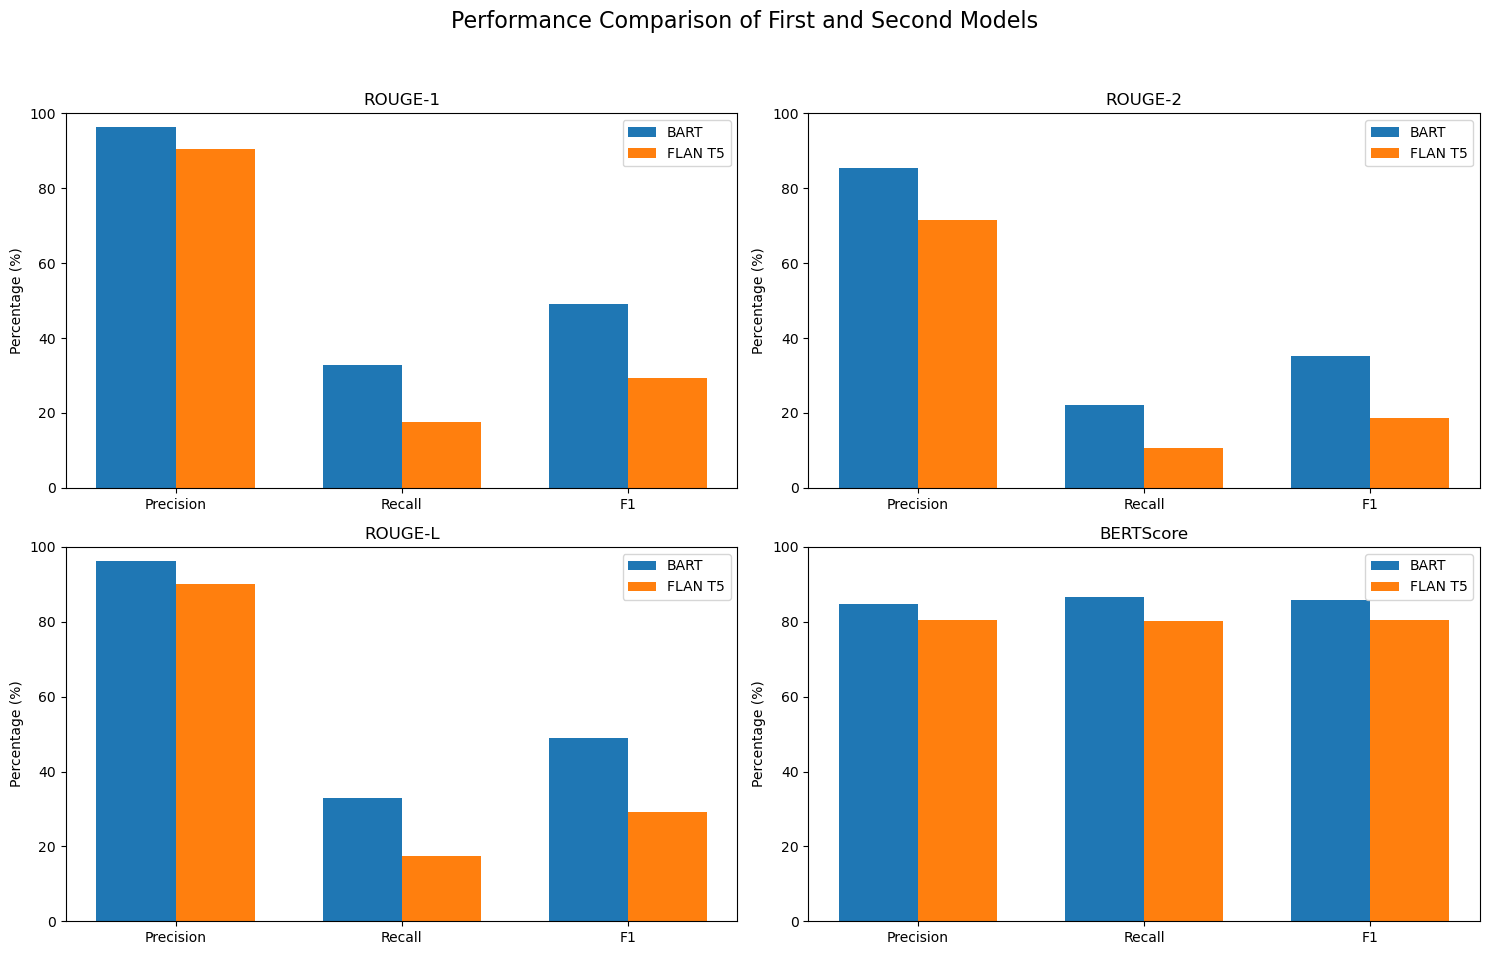

In [3]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    "ROUGE-1": {"BART": [96.33, 32.81, 48.95], "FLAN T5": [90.48, 17.49, 29.31]},
    "ROUGE-2": {"BART": [85.29, 22.12, 35.13], "FLAN T5": [71.49, 10.68, 18.58]},
    "ROUGE-L": {"BART": [96.33, 32.81, 48.95], "FLAN T5": [90.13, 17.42, 29.20]},
    "BERTScore": {"BART": [84.80, 86.56, 85.67], "FLAN T5": [80.45, 80.23, 80.34]}
}
categories = ["Precision", "Recall", "F1"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (metric, data) in enumerate(metrics.items()):
    x = np.arange(len(categories))  
    width = 0.35  
    axes[i].bar(x - width/2, data["BART"], width, label="BART")
    axes[i].bar(x + width/2, data["FLAN T5"], width, label="FLAN T5")
    axes[i].set_title(metric)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories)
    axes[i].set_ylim(0, 100)  
    axes[i].set_ylabel("Percentage (%)")
    axes[i].legend()

fig.suptitle("Performance Comparison of First and Second Models", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
